Problem statement:

Situation: Energy is produced in different forms and consumed by the regions in different rates.   

Complication: Energy prices are increasing due to many reasons including but not limited to war, logistics and sanctions.   

Question: Is it possible to see what types of energy have been historically produced and consumed by the different regions? Is it possible to predict how the productions and consumption will look like in the future?   

Answer: ???


In [346]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid', palette='crest')
import matplotlib.pyplot as plt


from sklearn.datasets import load_diabetes  # our diabetes dataset
from sklearn.model_selection import (
    train_test_split,
)  # will allow us to helpfully subdivide our data
from sklearn.linear_model import (
    LinearRegression,
)  # a simple model we can play around with

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.base import ForecastingHorizon


from sktime.forecasting.theta import ThetaForecaster

from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.ets import AutoETS

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [347]:
leveranser_flytande = pd.read_table('../data/to-use/leveranser-flytande-bransle-region-ar.csv', sep=',')
elproduction_bransleanvandning = pd.read_table('../data/to-use/elproduction-bransleanvandning-region-produktionssatt-bransletyp-ar.csv', sep=',')
fjarrvarmeproduktion = pd.read_table('../data/to-use/fjarrvarmeproduktion-region-produktionssatt-bransletyp-ar.csv', sep=',')
slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')
bransleforbrukning = pd.read_table('../data/to-use/branslefarbrukning-far-produktion-per-ar.csv', sep=',')
energidata = pd.read_table('../data/to-use/energidata-per-ar.csv', sep=',')

datasets = [leveranser_flytande, elproduction_bransleanvandning, 
            fjarrvarmeproduktion, slutanvandning, bransleforbrukning, energidata]


## FIll NAs
leveranser_flytande.m3 = leveranser_flytande.m3.fillna(method='ffill')
fjarrvarmeproduktion.MWh = fjarrvarmeproduktion.MWh.interpolate()
# slutanvandning = slutanvandning.fillna('fffill')
energidata.MWh = energidata.MWh.fillna(method='ffill')

## Remove '..' values
bransleforbrukning = bransleforbrukning.replace('..', 0)
bransleforbrukning.branslefarbrukning = bransleforbrukning.branslefarbrukning.astype(int)

energidata = energidata.replace('..', 0)
energidata.MWh = energidata.MWh.astype(int)

# Slice dataset for regions
leveranser_flytande = leveranser_flytande[leveranser_flytande.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
elproduction_bransleanvandning = elproduction_bransleanvandning[elproduction_bransleanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion[fjarrvarmeproduktion.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
slutanvandning = slutanvandning[slutanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
energidata = energidata[energidata.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)


## Group datasets
leveranser_flytande = leveranser_flytande.groupby(['region', 'ar', 'fornybar_bransletyp'], as_index=False).agg(Sum=('m3', np.sum)).reset_index(drop=True)
elproduction_bransleanvandning_grouped = elproduction_bransleanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
slutanvandning = slutanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'forbrukarkategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
bransleforbrukning = bransleforbrukning.groupby(['ar', 'fornybar_bransletyp', 'produktionsslag'], as_index=False).agg( Sum=('branslefarbrukning', np.sum)).reset_index(drop=True)
energidata = energidata.groupby(['region', 'ar', 'fornybar_energityp', 'fornybar_kategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)

bransleforbrukning.Sum = bransleforbrukning.Sum.astype(float)

# leveranser_flytande.ar = pd.to_datetime(leveranser_flytande.ar, format='%Y').dt.year
# elproduction_bransleanvandning_grouped.ar = pd.to_datetime(elproduction_bransleanvandning_grouped.ar, format='%Y-%m-%d').dt.year
# fjarrvarmeproduktion.ar = pd.to_datetime(fjarrvarmeproduktion.ar, format='%Y-%m-%d').dt.year
# slutanvandning.ar = pd.to_datetime(slutanvandning.ar, format='%Y-%m-%d').dt.year
# bransleforbrukning.ar = pd.to_datetime(bransleforbrukning.ar, format='%Y-%m-%d').dt.year
# energidata.ar = pd.to_datetime(energidata.ar, format='%Y-%m-%d').dt.year



C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_5704\2380895521.py:4: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')


In [348]:
# Constants

AR = 'ar'
M3 = 'm3'
MWH = 'MWh'

BRANSLETYP = 'bransletyp'
FARBRUKARKATEGORI = 'farbrukarkategori'
PRODUCTIONSSATT = 'produktionssatt'
KATEGORI = 'kategori'
ENERGITYP = 'energityp'
PRODUCTIONSSLAG = 'produktionsslag'
BRANSLEFORBRUKNING = 'bransleforbukning'

REGION = 'region'

FORNYBAR_BRANSLETYP = 'fornybar_bransletyp'
FORNYBAR_PRODUCTIONSSATT = 'fornybar_produktionssatt'
FORNYBAR_PRODUCTIONSSLAG = 'fornybar_produktionssatt'
FORNYBAR_ENERGITYP = 'fornybar_energityp'
FORNYBAR_KATEGORI = 'fornybar_kategori'


In [349]:
encodeList = [REGION, FORNYBAR_BRANSLETYP, FORNYBAR_PRODUCTIONSSATT, FORNYBAR_PRODUCTIONSSLAG, FORNYBAR_ENERGITYP, FORNYBAR_KATEGORI]

In [350]:
# for encode_item in encodeList:
#     if encode_item in leveranser_flytande.columns:
#         leveranser_flytande[encode_item].replace(leveranser_flytande[encode_item].unique(), range(
#             0, len(leveranser_flytande[encode_item].unique())), inplace=True)

for each of the dataframes (not a level of the nexted loop; manualy copied block):

for each region:   
    for each type of energy:   
        for each type of energy (if needed):    
            find the max of ar    
            create series with range ar.max+1:a.max+6   
            create a series with ar as index and Sum as value   
            plot and fit the forcaters   


look into https://stackoverflow.com/questions/55311036/using-binary-encoding-how-to-get-the-original-values-back-from-encoded-values for the encoding so I can get the values back.

00 Riket
fornybar
icke-fornybar
okand
01 Stockholms l�n
fornybar
icke-fornybar
okand
0117 �ster�ker
fornybar
icke-fornybar
okand
0160 T�by
fornybar
icke-fornybar
okand
0180 Stockholm
fornybar
icke-fornybar
okand
09 Gotlands l�n
fornybar
icke-fornybar
okand
0980 Gotland
fornybar
icke-fornybar
okand
1480 G�teborg
fornybar
icke-fornybar
okand
22 V�sternorrlands l�n
fornybar
icke-fornybar
okand
2581 Pite�
fornybar
icke-fornybar
okand


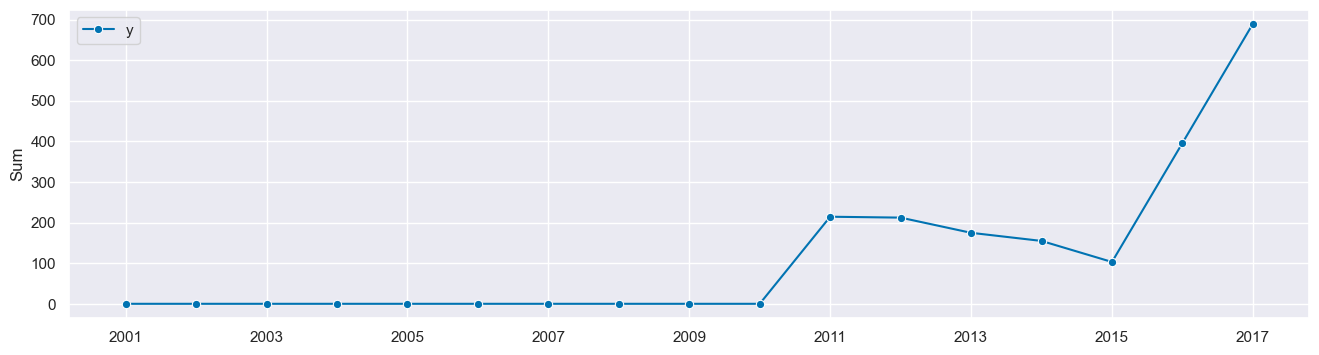

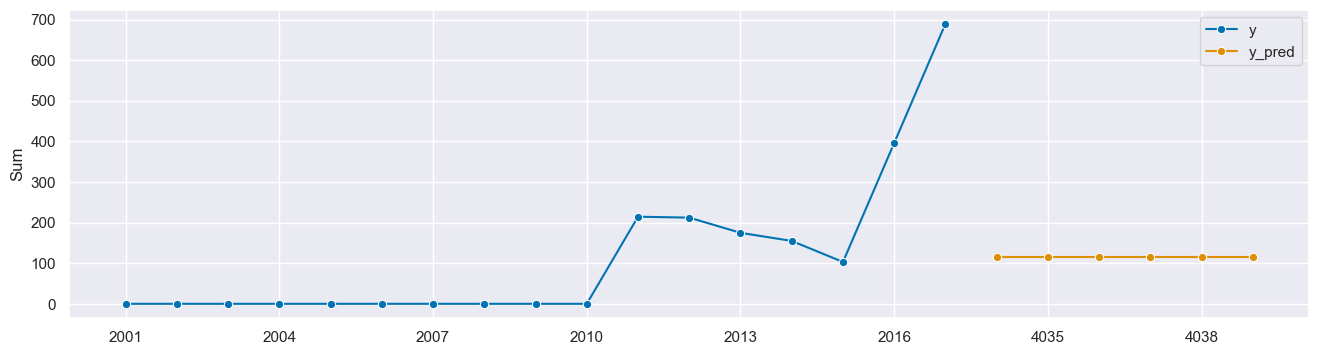

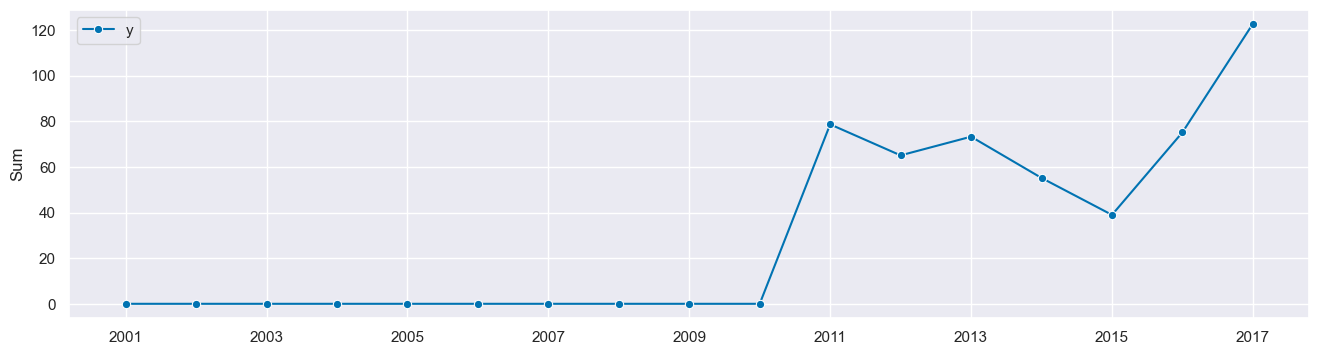

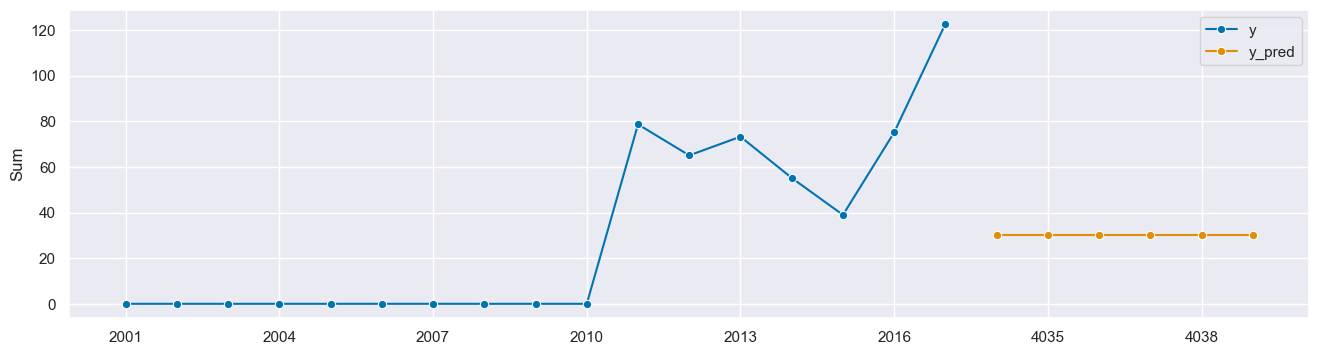

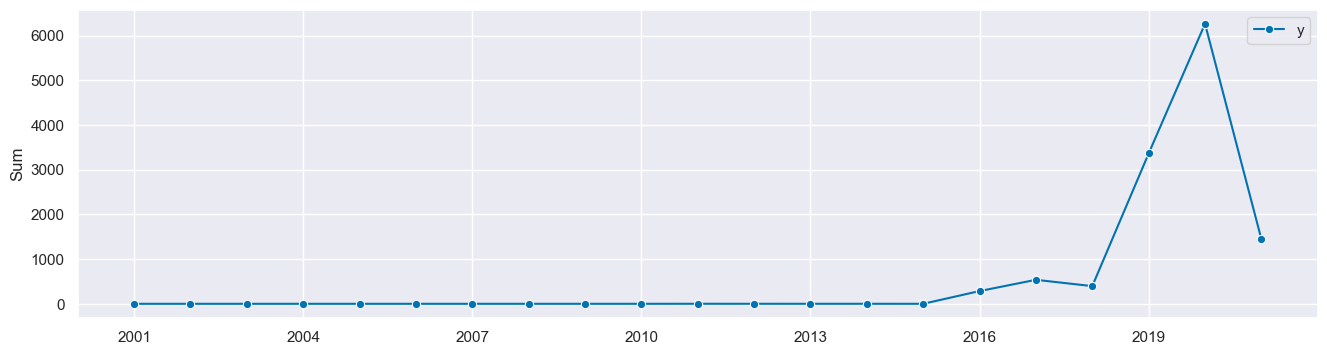

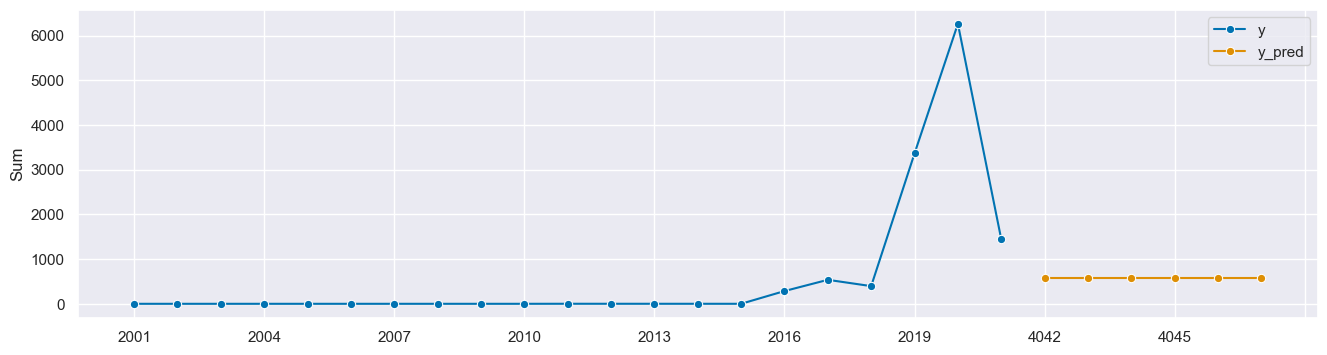

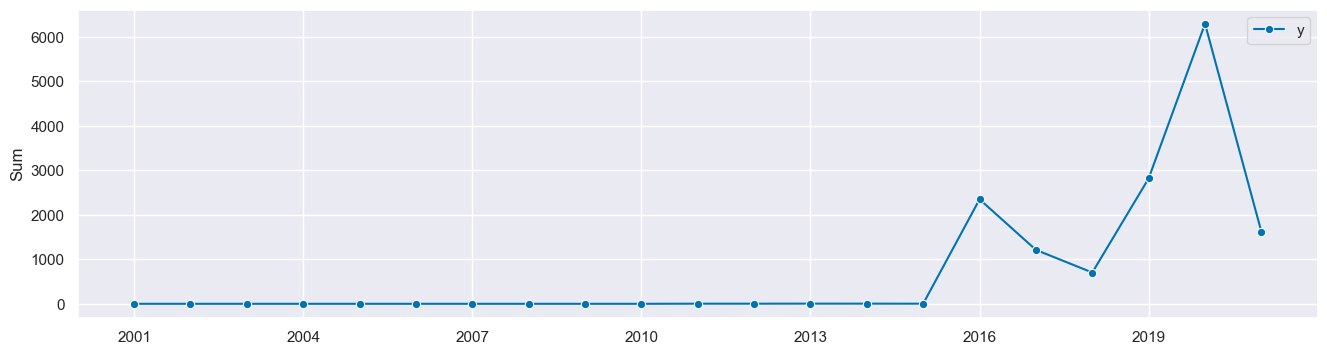

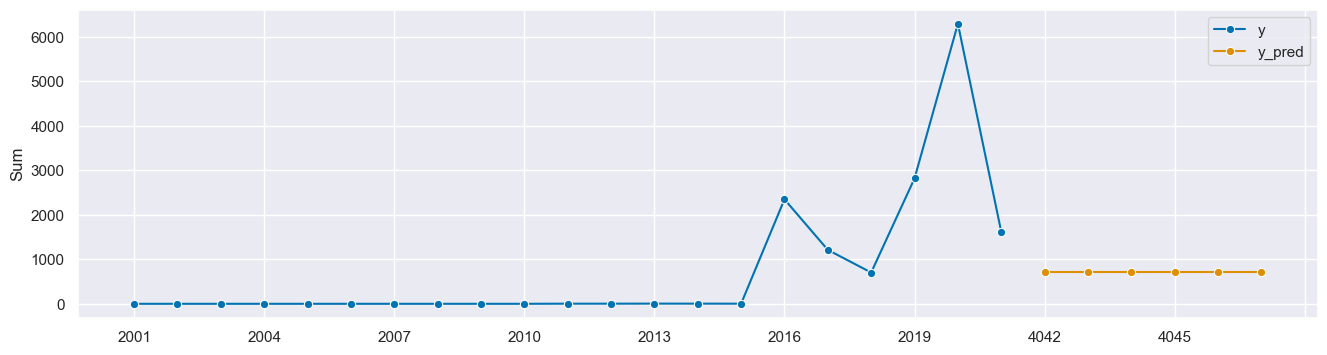

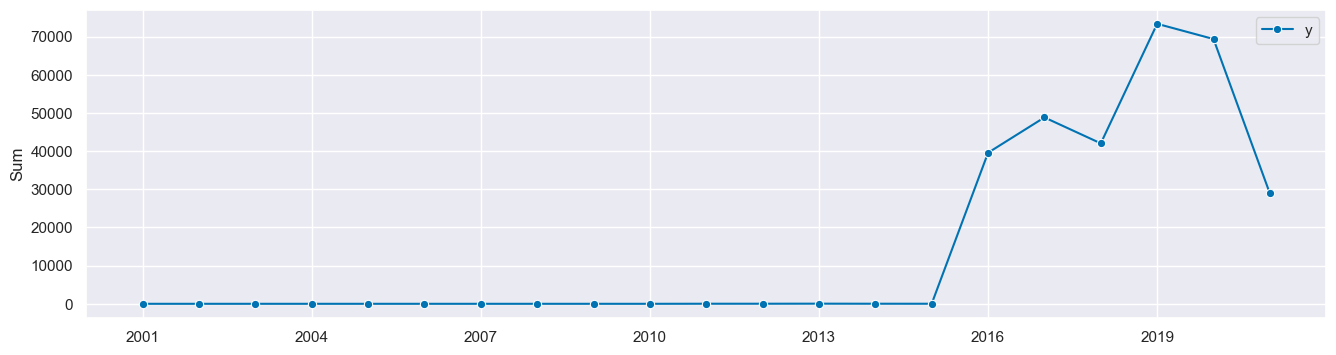

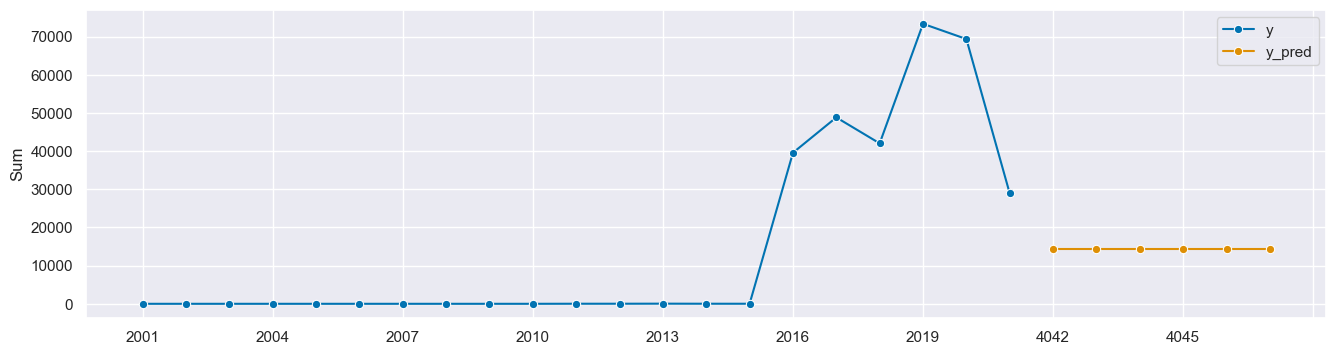

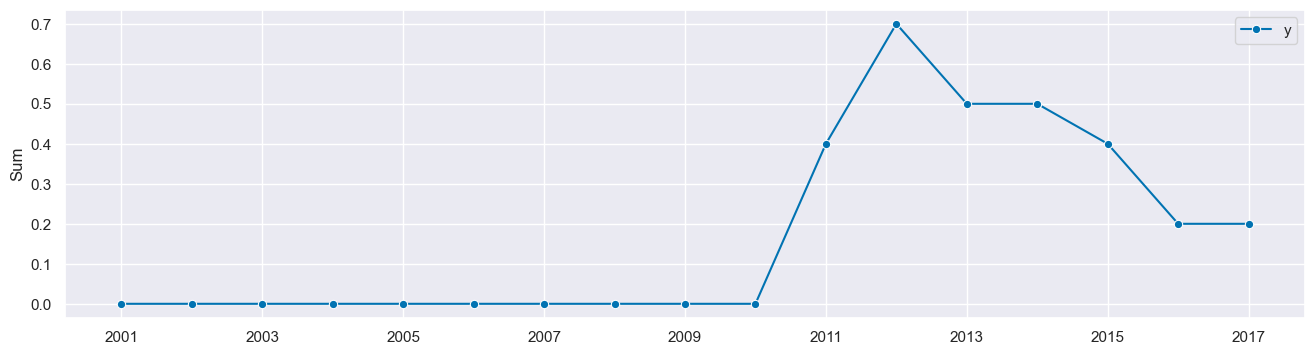

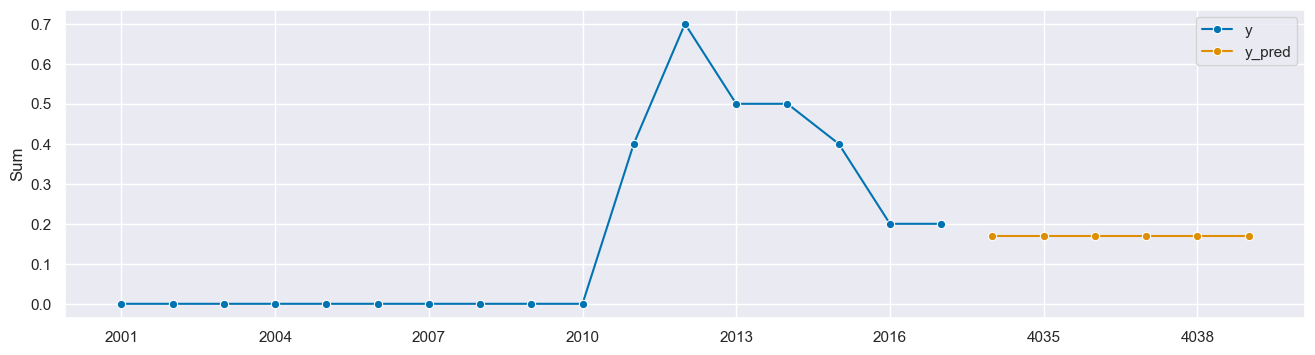

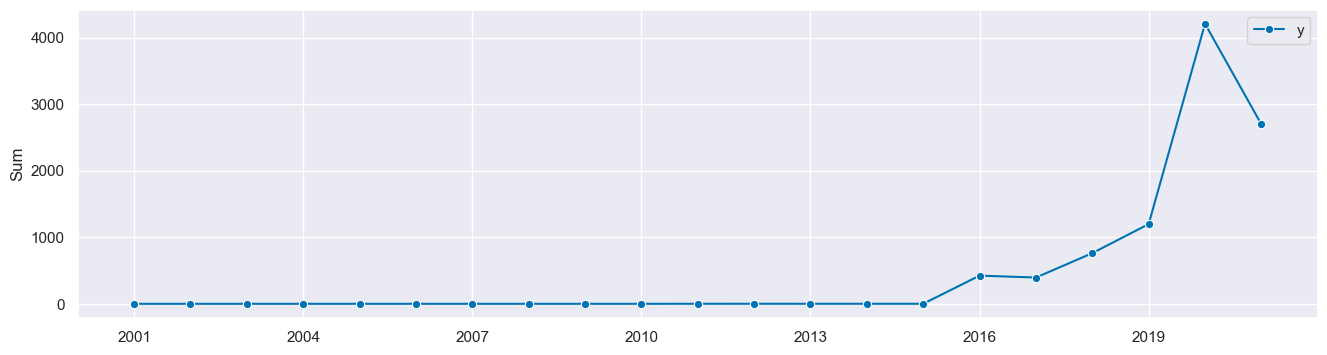

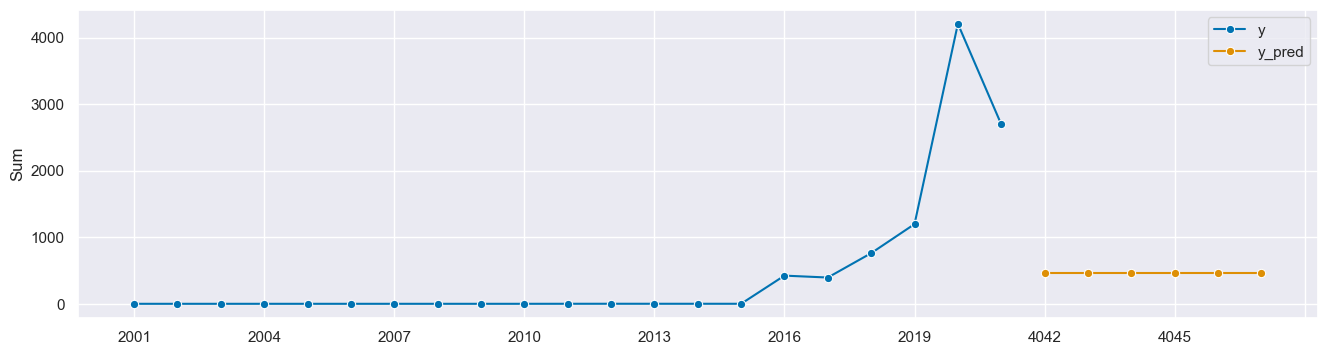

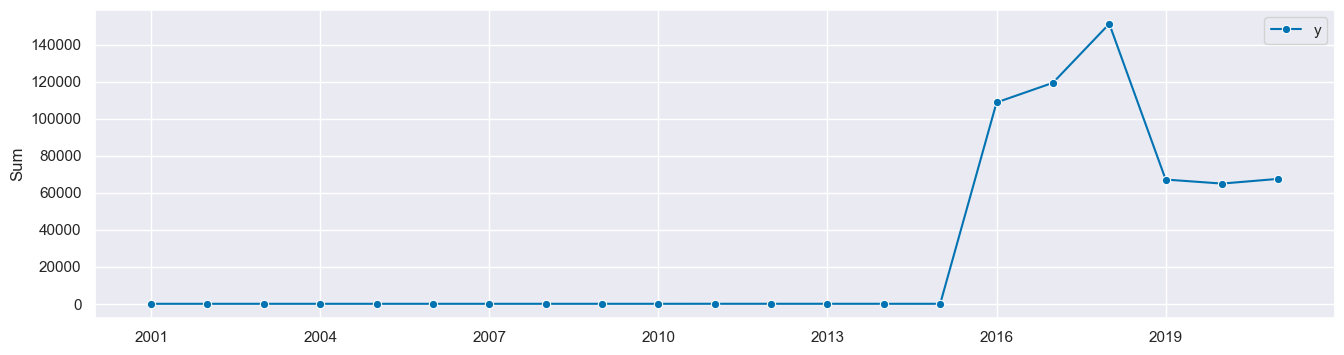

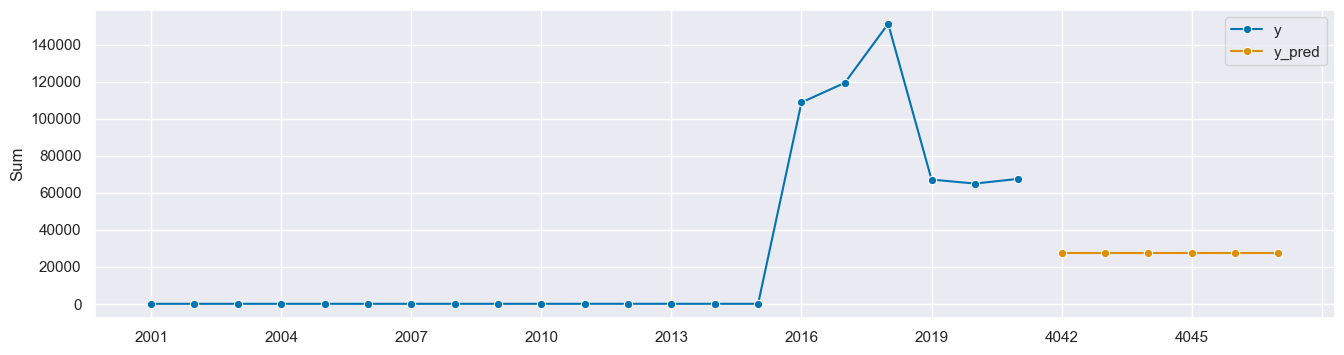

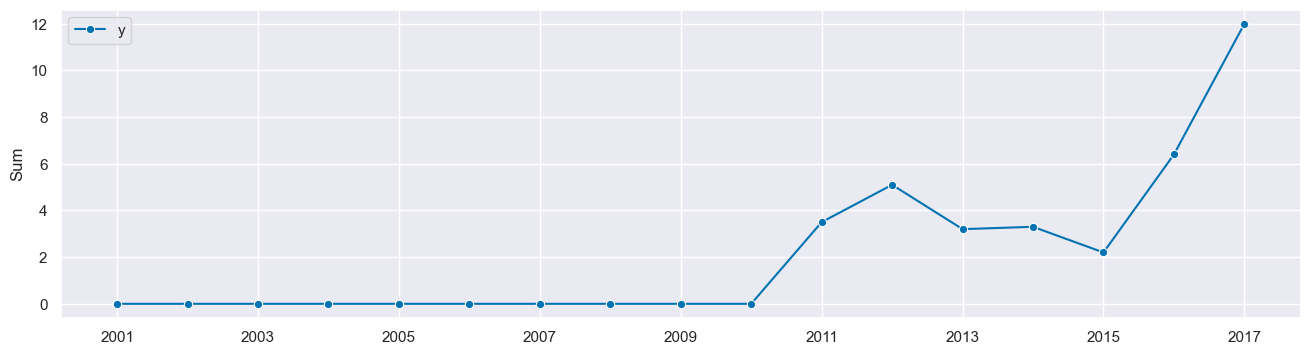

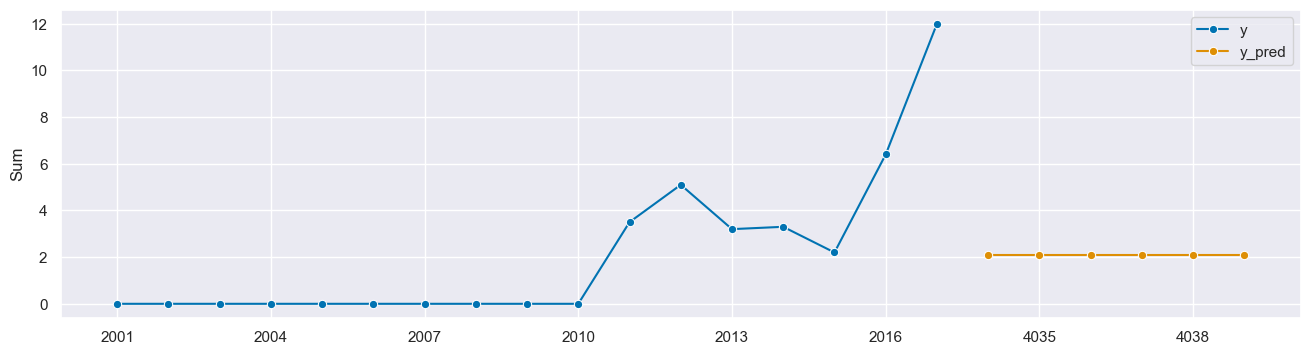

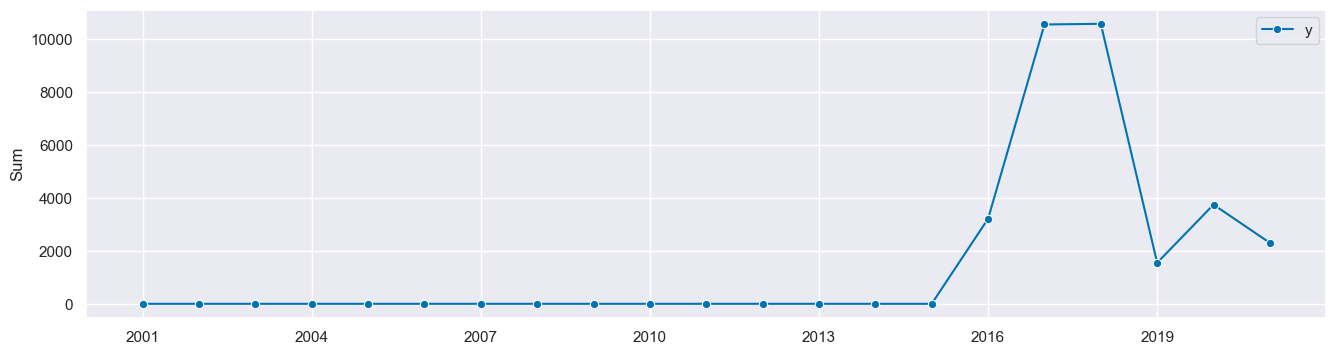

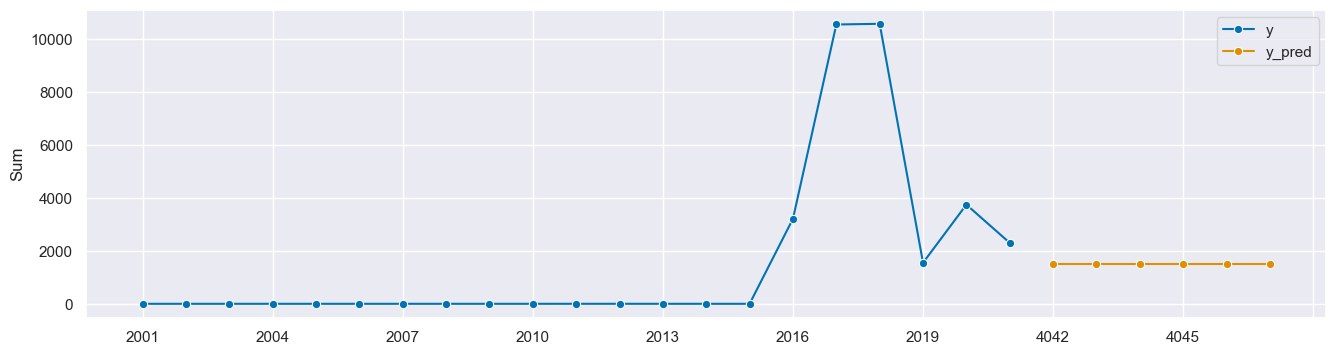

In [351]:
# leveranser_flytande

for region in leveranser_flytande.region.drop_duplicates(keep='first').reset_index(drop=True):
    print(region)
    data = leveranser_flytande[leveranser_flytande.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        print(fornybar_bransletyp)
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        if not data.empty:
            # print(data.ar.max())
            # print(data.ar.min())
            ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
            # print(ey)
            # if not data.ar[~data.ar.isin(ey)]:
            # print(data.ar - ey)       
            
            y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
            # print(y)
            plot_series(y, labels=['y'])
            # Instantiate NaiveForecaster:
            fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
            forecaster = NaiveForecaster(strategy='mean')
            # Fit NaiveForecaster:
            forecaster.fit(y)

            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Check it out:
            plot_series(y, y_pred, labels=["y", "y_pred"])

                        
            # # Instantiate:
            # forecaster = ThetaForecaster(sp=12)

            # # Fit:
            # forecaster.fit(y)

            # # Predict:
            # y_pred_theta = forecaster.predict(fh)

            # Check it out:
            # plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

            # # Instantiate ARIMA
            # forecaster = AutoARIMA(sp=12)
            # # Fit Arima
            # forecaster.fit(y)
            # # Predict Arima 
            # y_pred_ARIMA = forecaster.predict(fh)

            # # Check it out:
            # plot_series(y, y_pred, y_pred_ARIMA, labels=["y", "y_pred_naive", "y_pred_ARIMA"])

            # # Instantiate AutoETS
            # forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
            # # Fit AutoETS
            # forecaster.fit(y)
            # # Predict AutoETS 
            # y_pred_ETS = forecaster.predict(fh)

            # # Check it out:
            # plot_series(y, y_pred, y_pred_ETS, labels=["y", "y_pred_naive", "y_pred_ETS"])            
            # print("----------------")   

        # else:
        #     print("----------------")   




00 Riket
okand
01 Stockholms l�n
okand
0117 �ster�ker
okand
0160 T�by
okand
0180 Stockholm
okand
09 Gotlands l�n
okand
0980 Gotland
okand
1480 G�teborg
okand
22 V�sternorrlands l�n
okand
2581 Pite�
okand


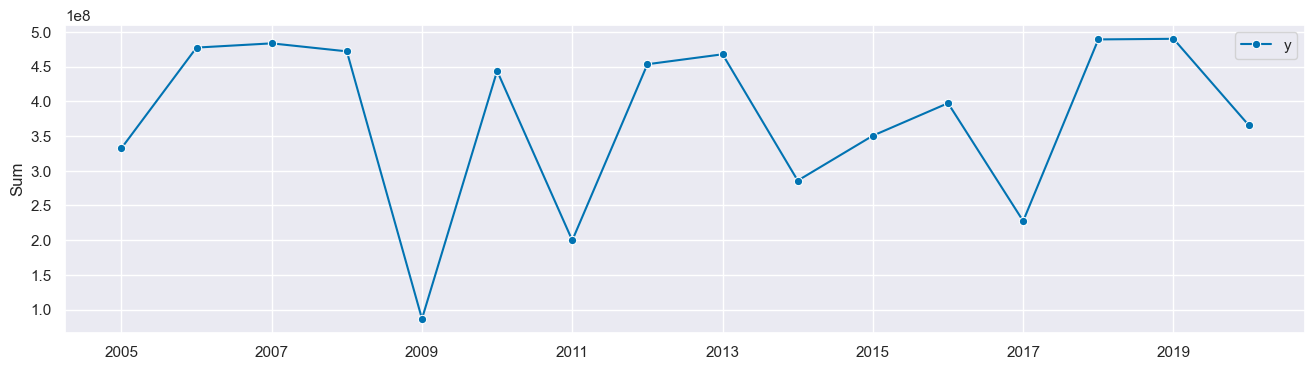

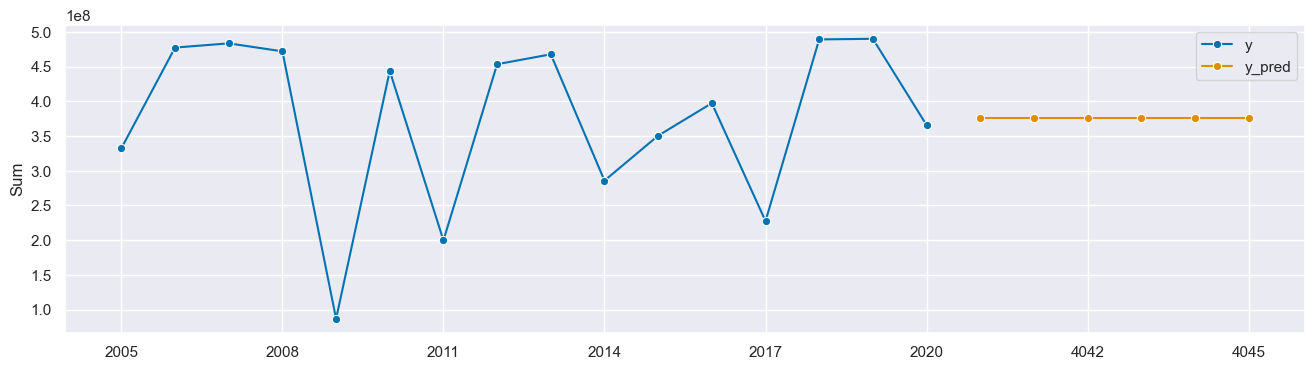

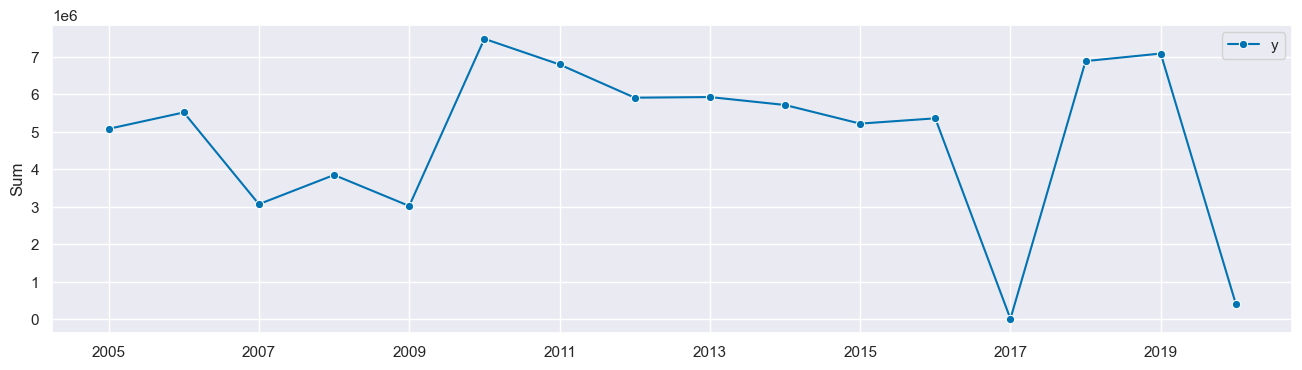

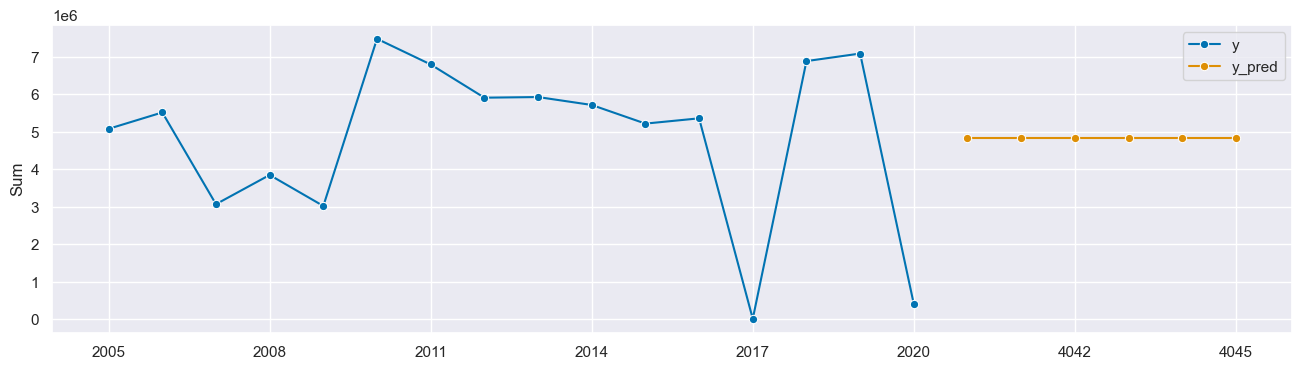

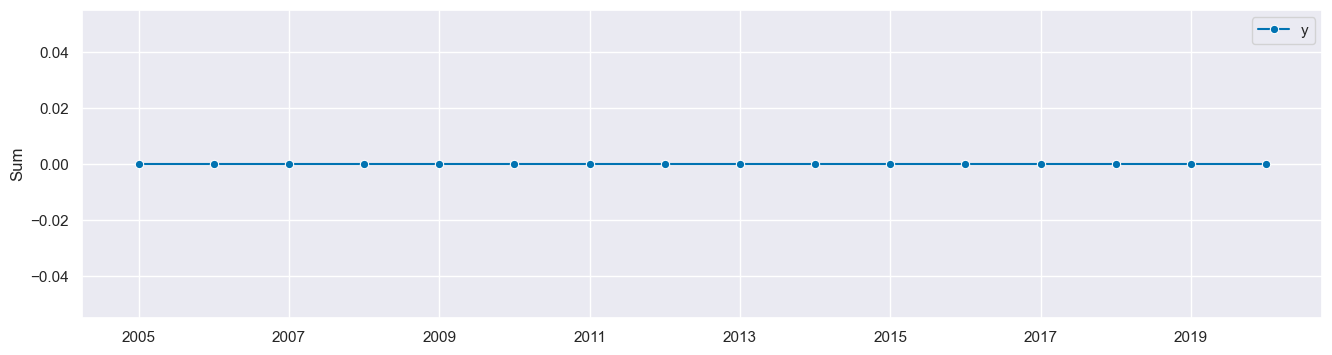

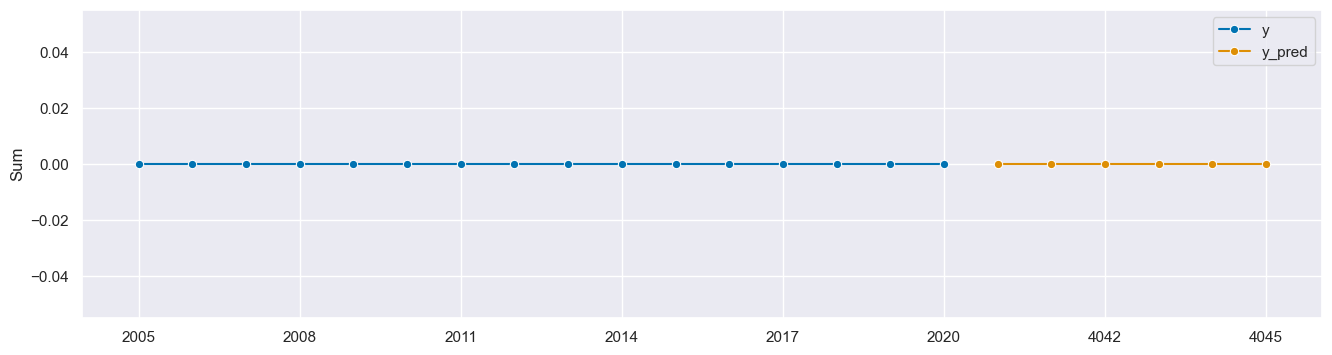

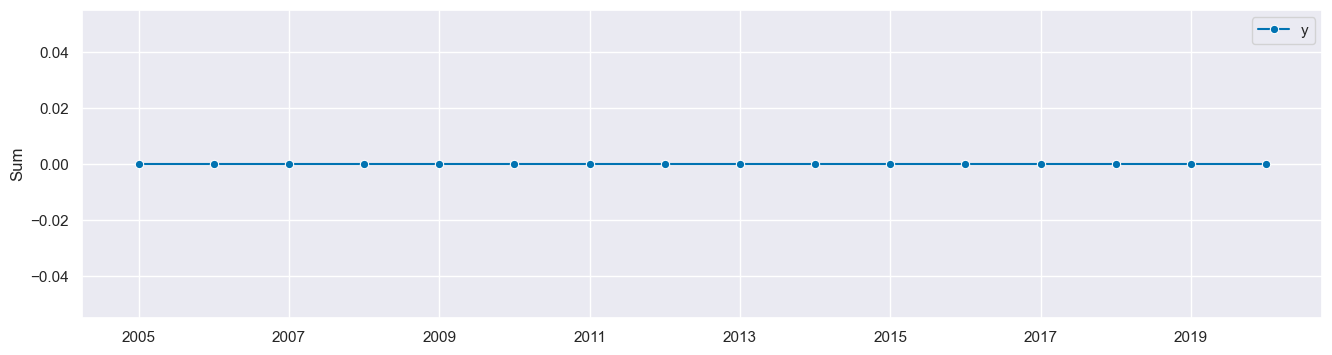

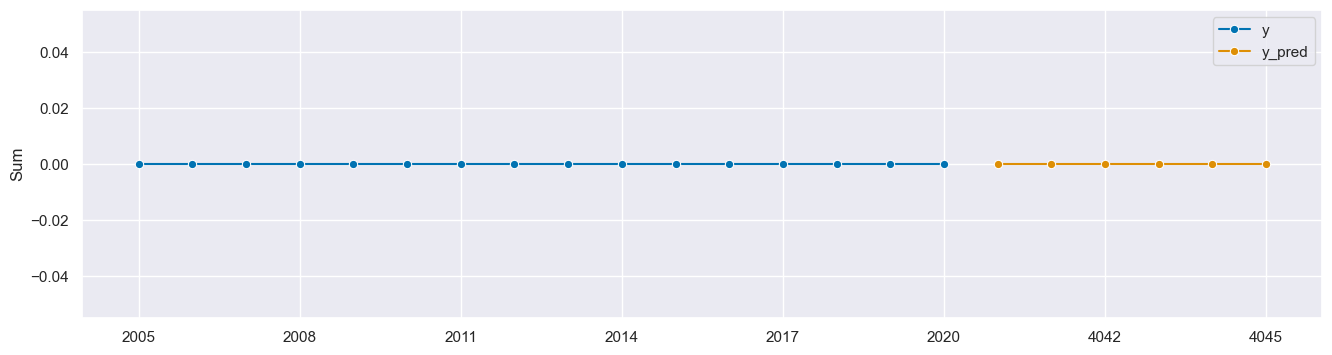

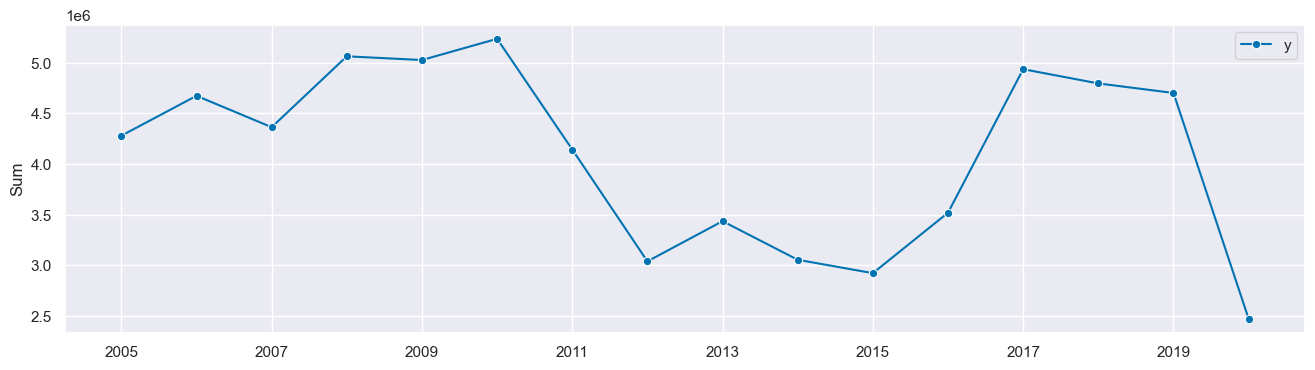

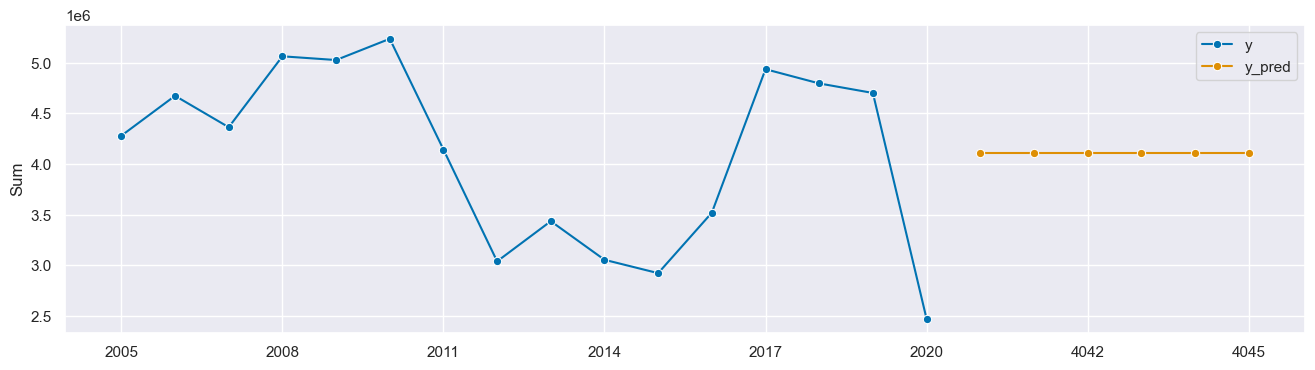

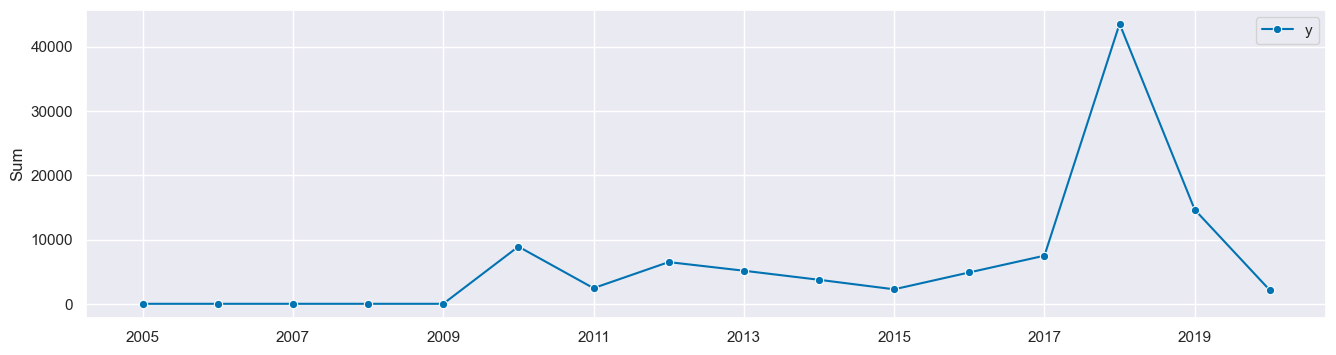

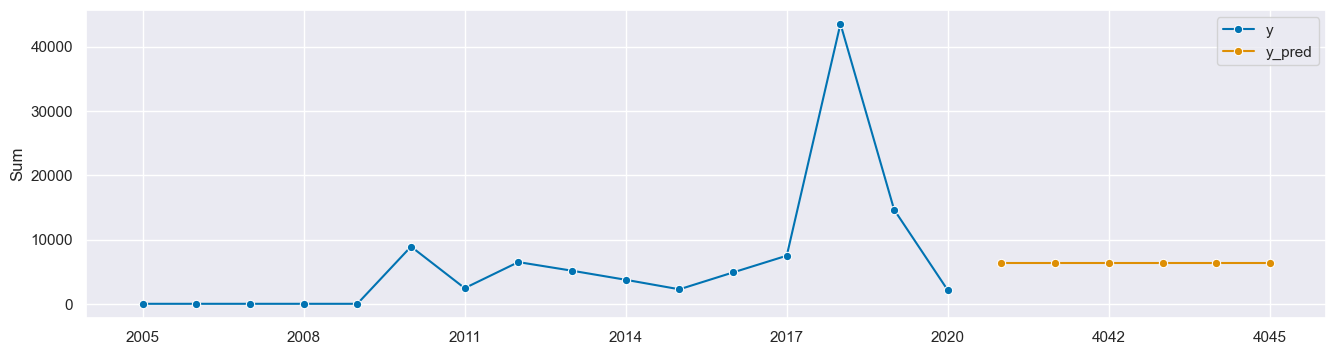

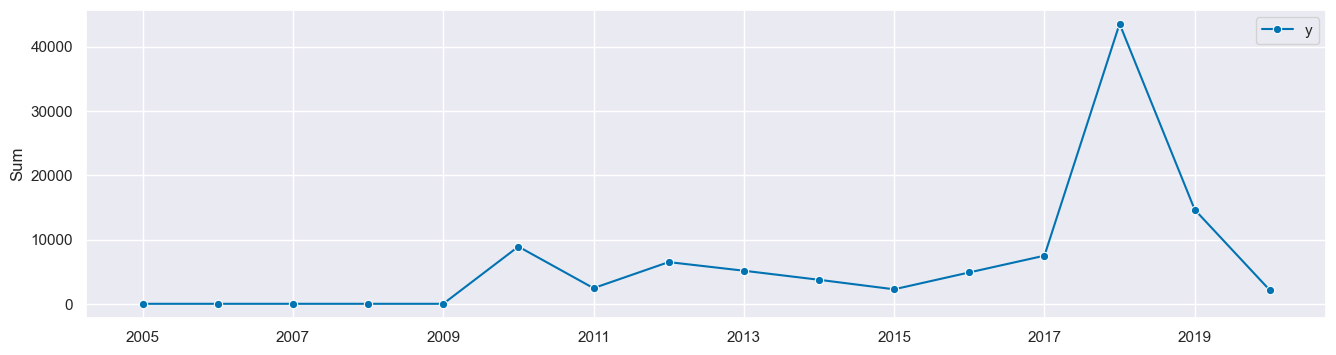

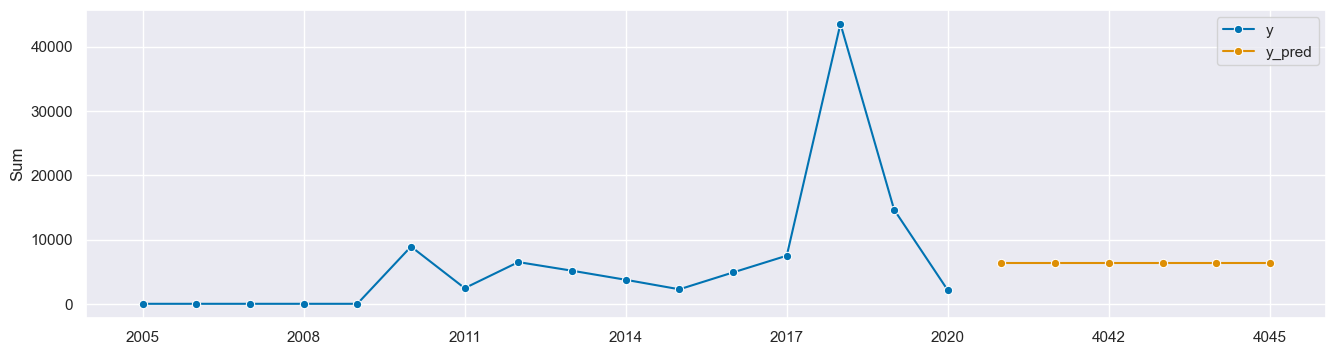

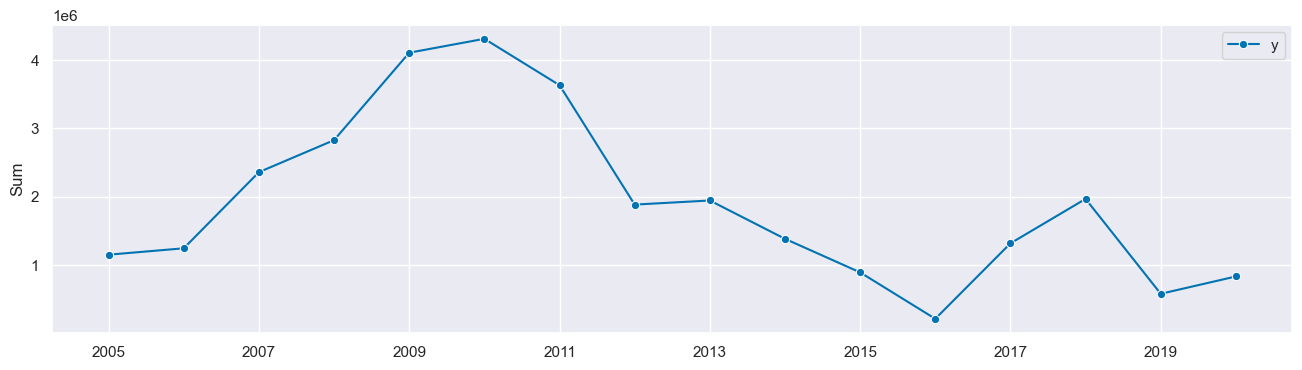

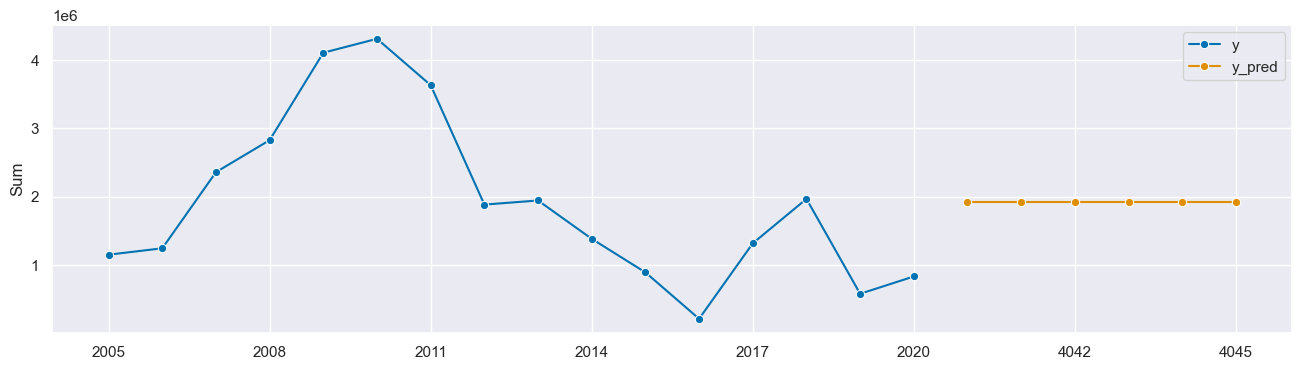

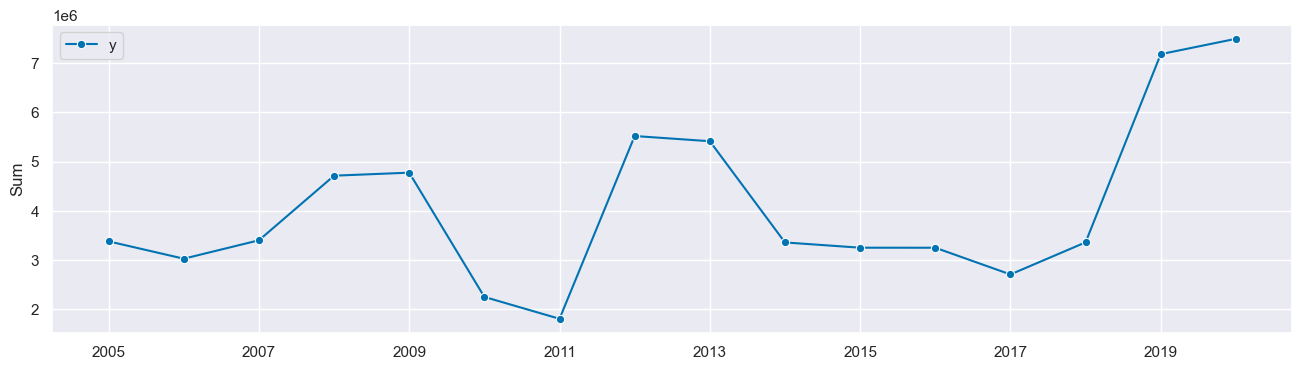

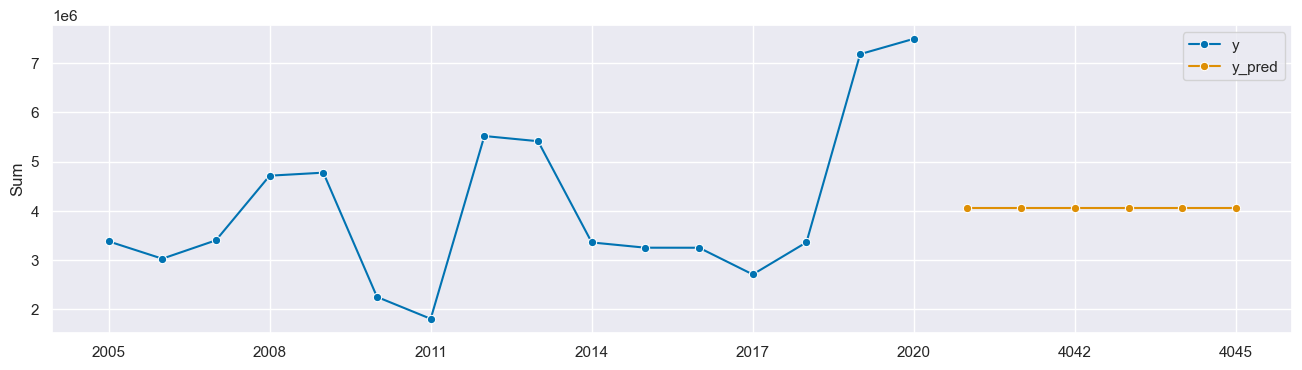

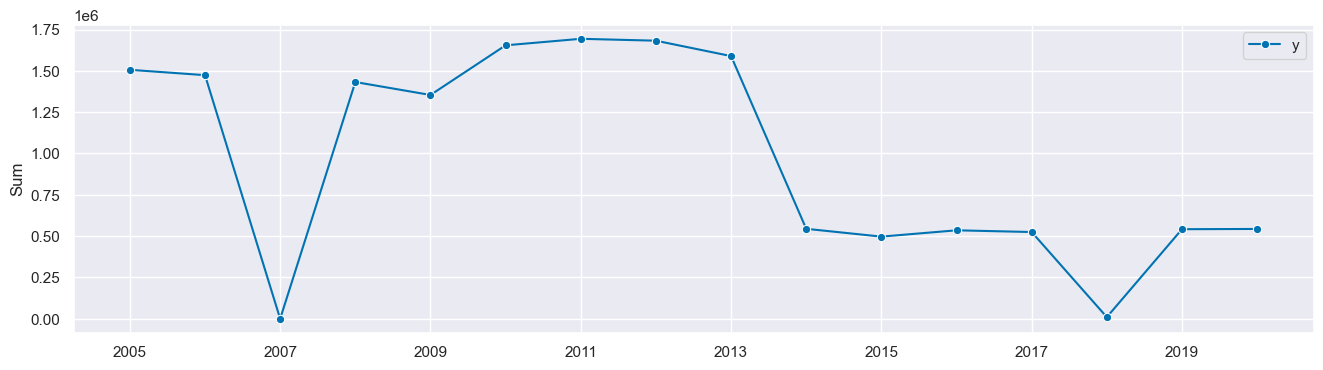

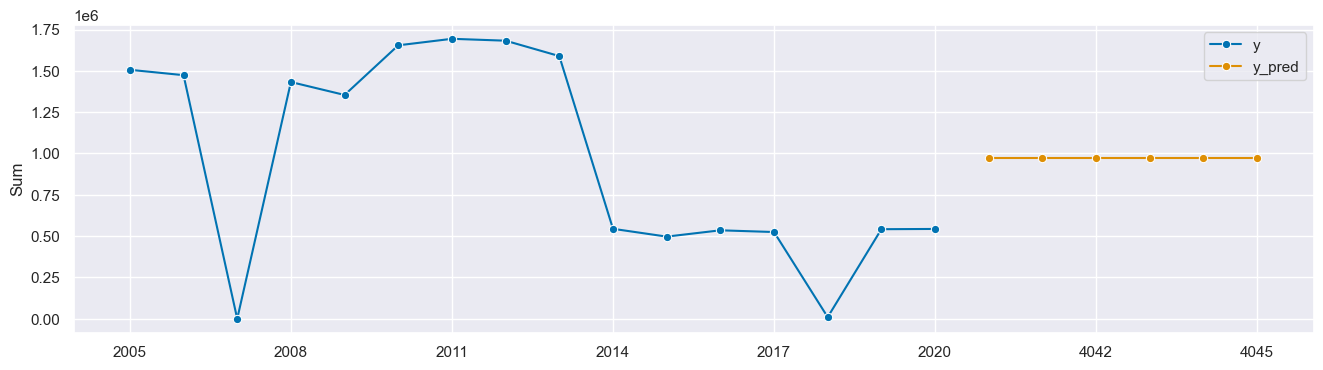

In [352]:
# elproduction_bransleanvandning_grouped
for region in elproduction_bransleanvandning_grouped.region.drop_duplicates(keep='first').reset_index(drop=True):
    print(region)
    data = elproduction_bransleanvandning_grouped[elproduction_bransleanvandning_grouped.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        print(fornybar_bransletyp)
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].sort_values(by=['ar'], ascending=True).reset_index(drop=True)

            if not data.empty:
                # print(data.ar.max())
                # print(data.ar.min())
                ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
                # print(ey)
                # if not data.ar[~data.ar.isin(ey)]:
                # print(data.ar - ey)       
                
                y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
                # print(y)
                plot_series(y, labels=['y'])
                # Instantiate NaiveForecaster:
                fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
                forecaster = NaiveForecaster(strategy='mean')
                # Fit NaiveForecaster:
                forecaster.fit(y)

                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Check it out:
                plot_series(y, y_pred, labels=["y", "y_pred"])

                            
                # # Instantiate:
                # forecaster = ThetaForecaster(sp=12)

                # # Fit:
                # forecaster.fit(y)

                # # Predict:
                # y_pred_theta = forecaster.predict(fh)

                # Check it out:
                # plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

                # # Instantiate ARIMA
                # forecaster = AutoARIMA(sp=12)
                # # Fit Arima
                # forecaster.fit(y)
                # # Predict Arima 
                # y_pred_ARIMA = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ARIMA, labels=["y", "y_pred_naive", "y_pred_ARIMA"])

                # Instantiate AutoETS
                # forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
                # # Fit AutoETS
                # forecaster.fit(y)
                # # Predict AutoETS 
                # y_pred_ETS = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ETS, labels=["y", "y_pred_naive", "y_pred_ETS"])            
                # print("----------------")   

            # else:
            #     print("----------------")   






00 Riket
okand
fornybar
okand
summa
01 Stockholms l�n
okand
fornybar
okand
summa
0117 �ster�ker
okand
fornybar
okand
summa
0160 T�by
okand
fornybar
okand
summa
0180 Stockholm
okand
fornybar
okand
summa
09 Gotlands l�n
okand
fornybar
okand
summa
0980 Gotland
okand
fornybar
okand
summa
1480 G�teborg
okand
fornybar
okand
summa
22 V�sternorrlands l�n
okand
fornybar
okand
summa
2581 Pite�
okand
fornybar
okand
summa


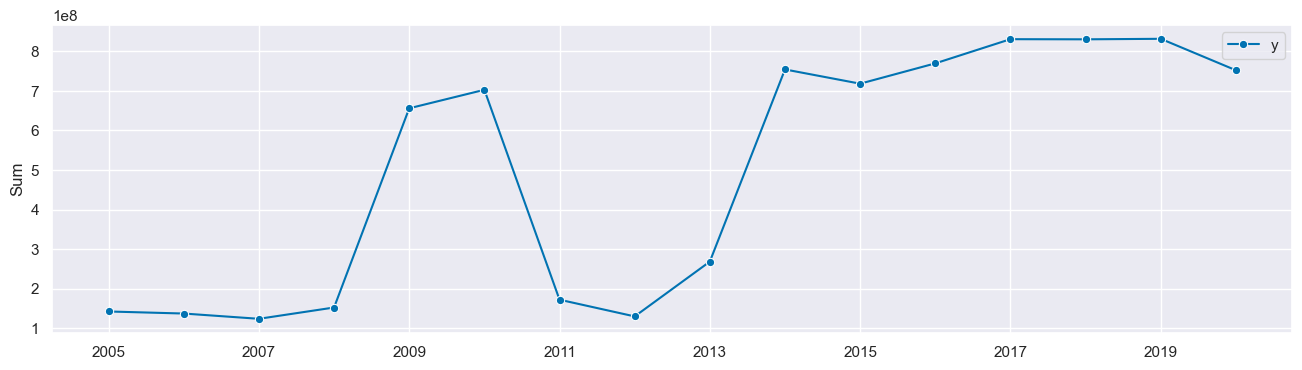

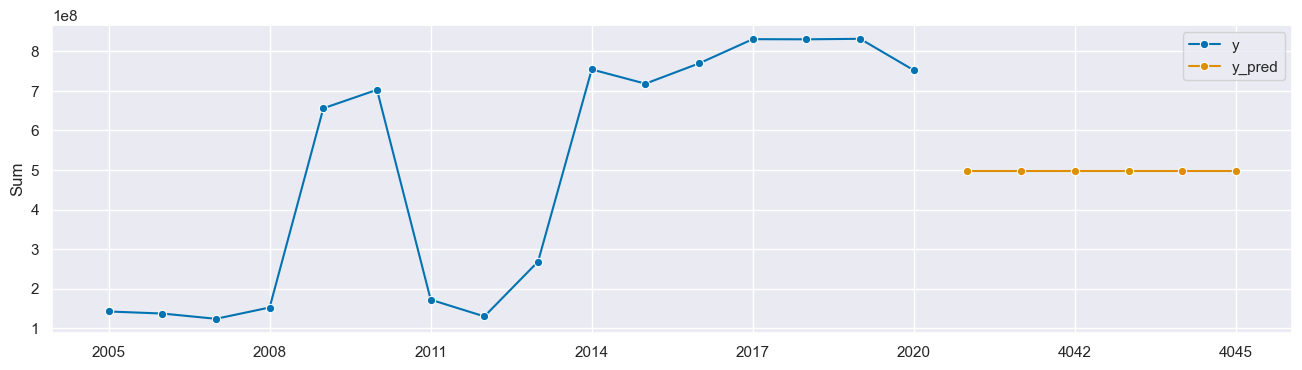

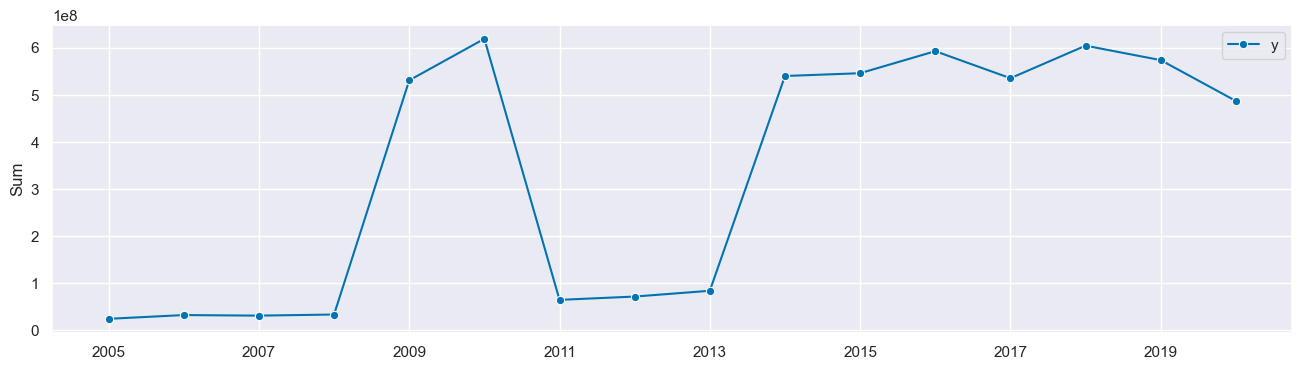

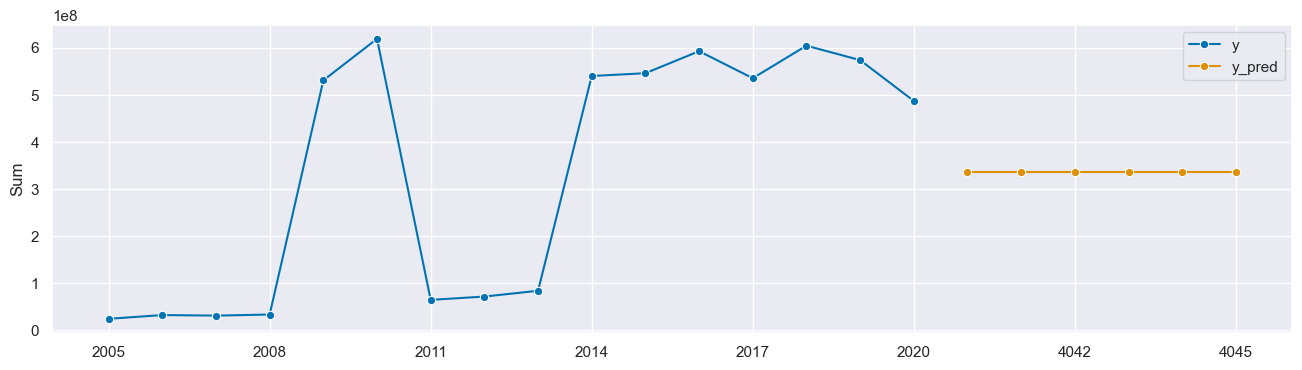

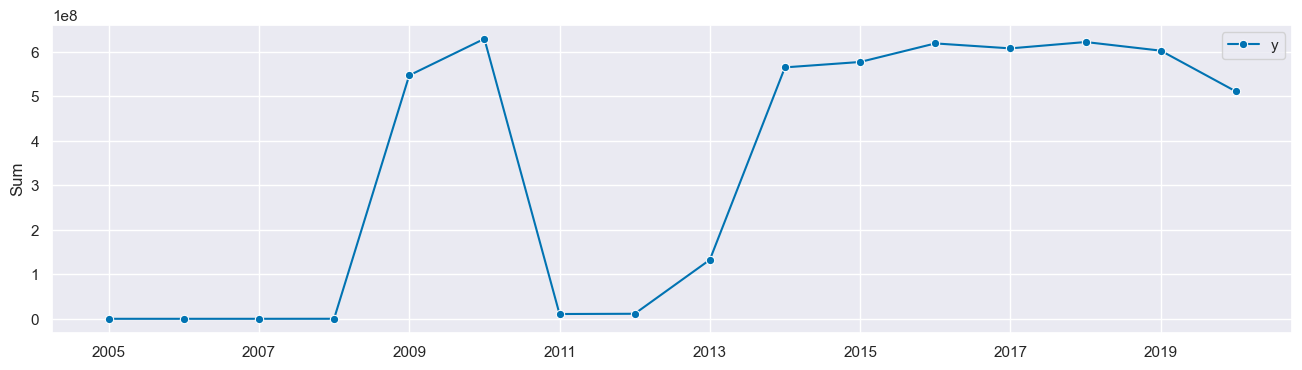

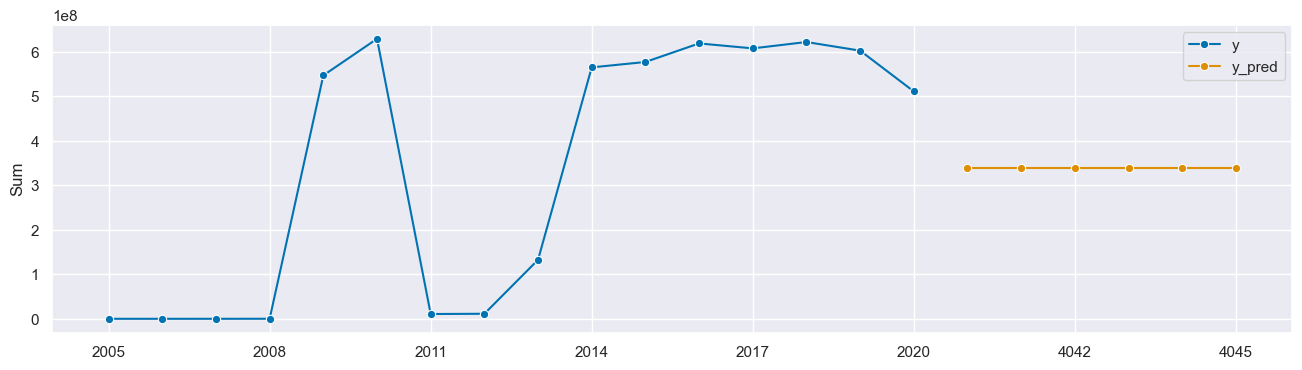

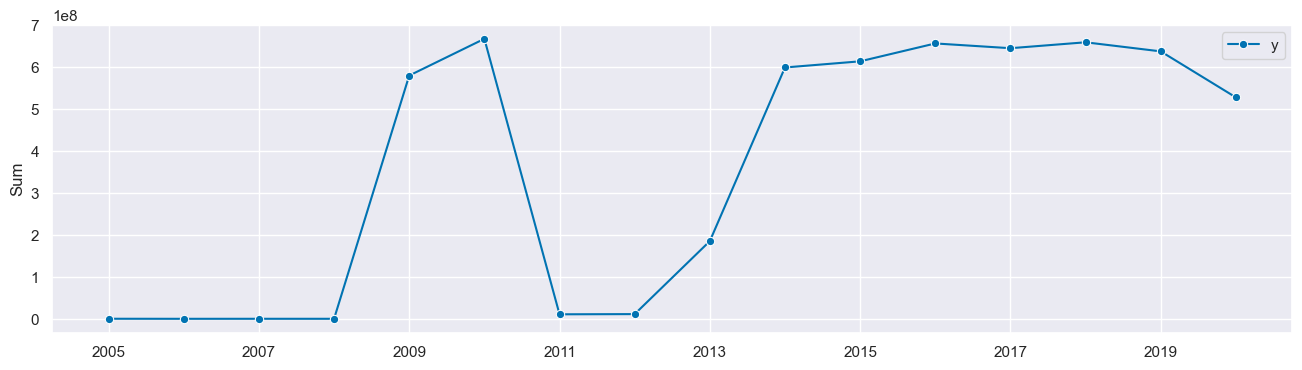

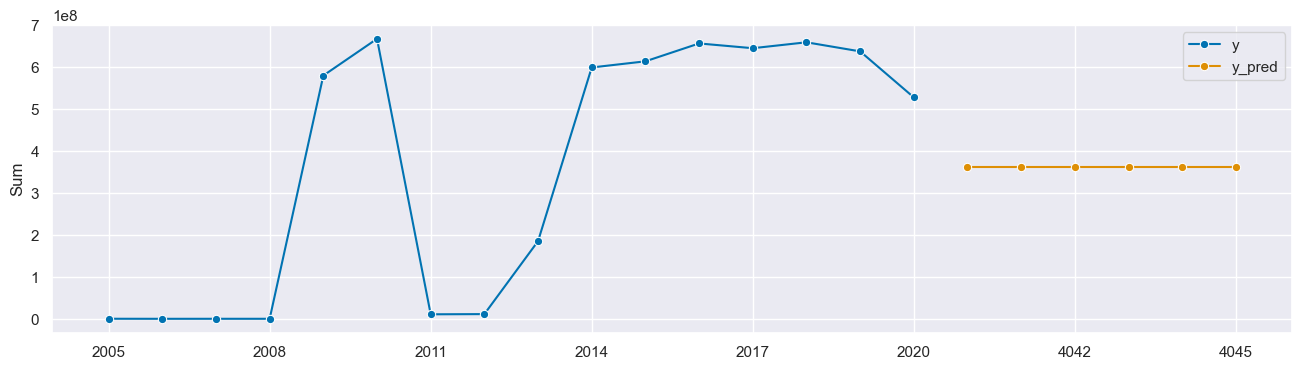

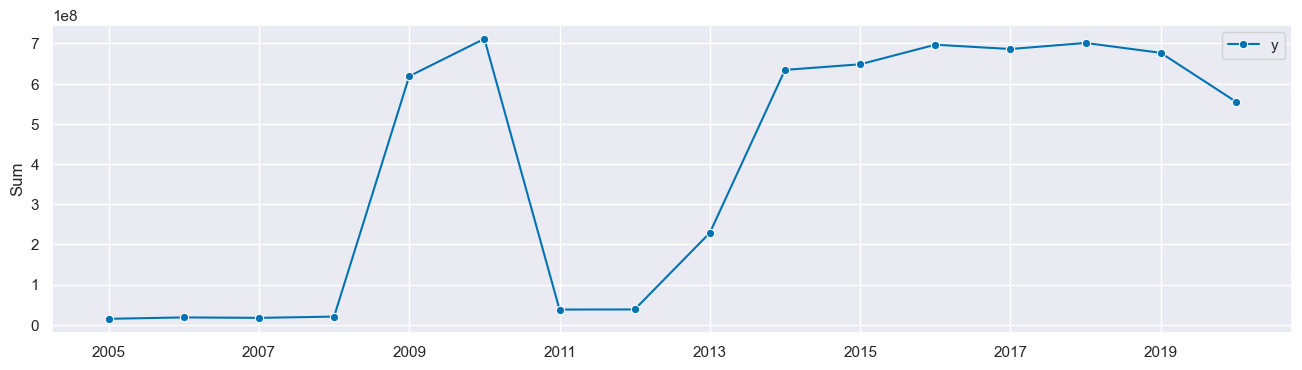

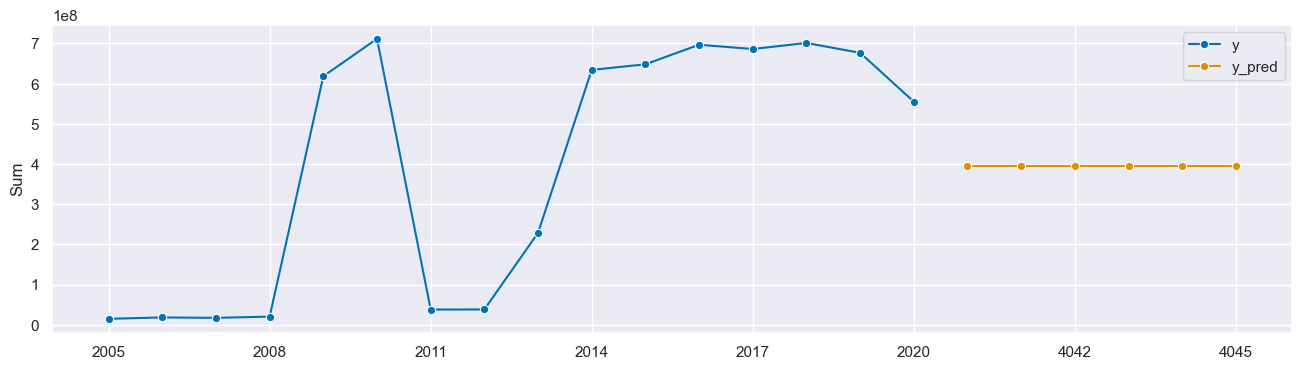

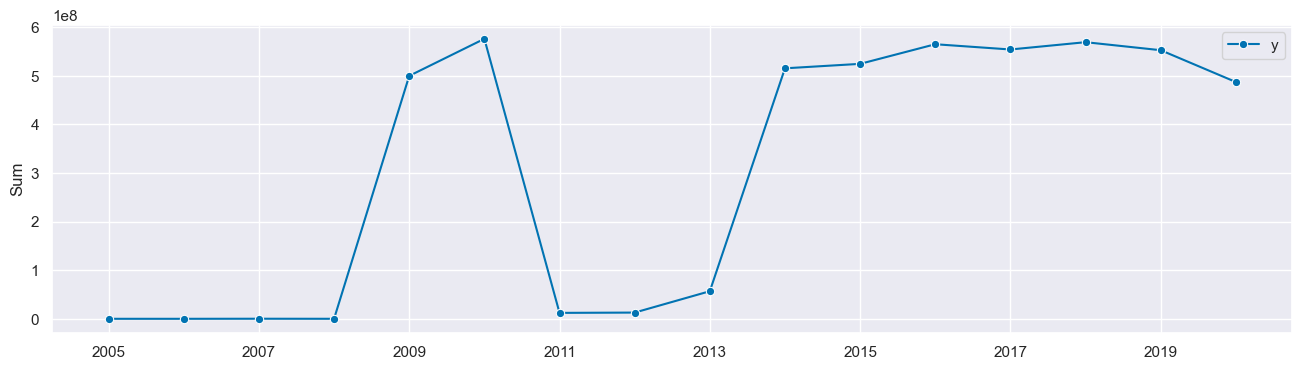

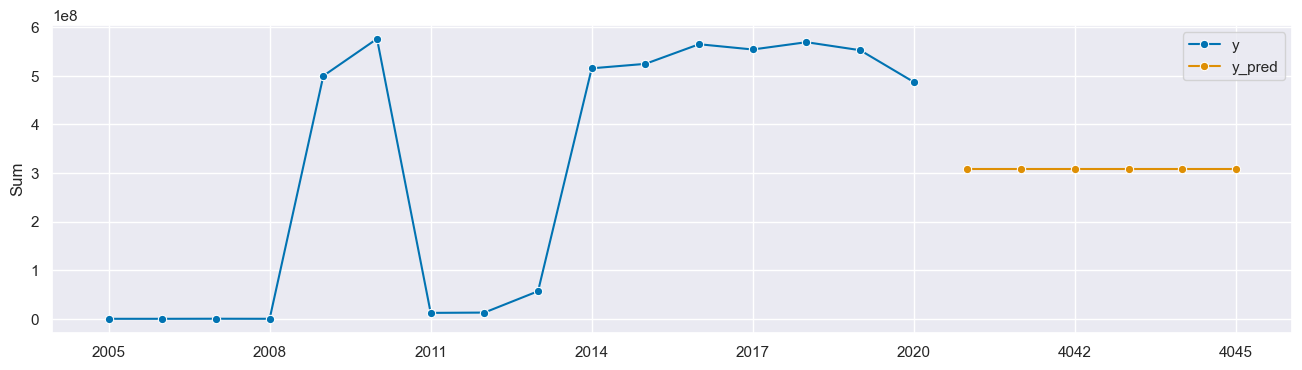

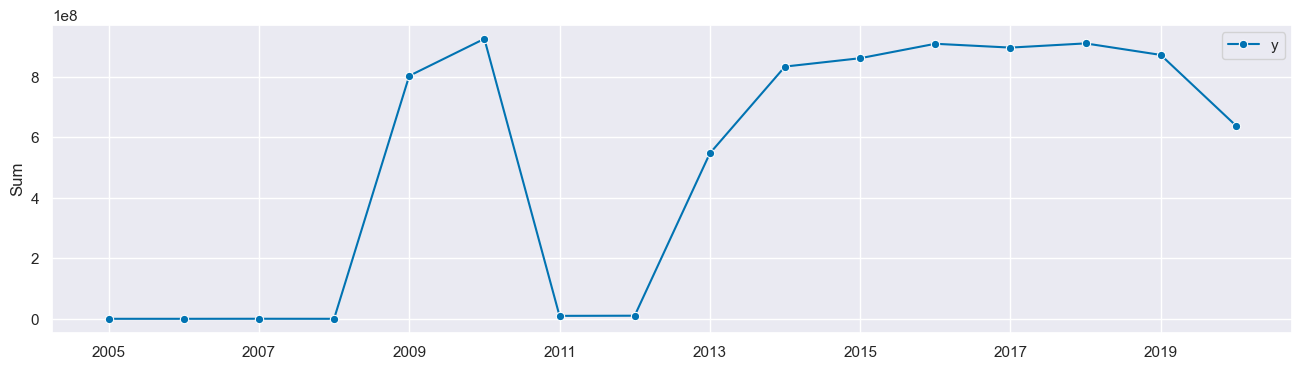

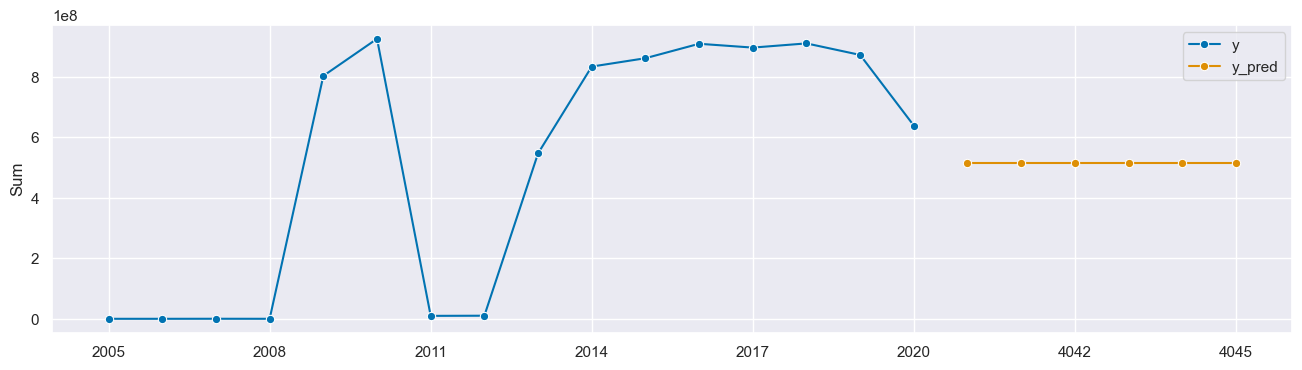

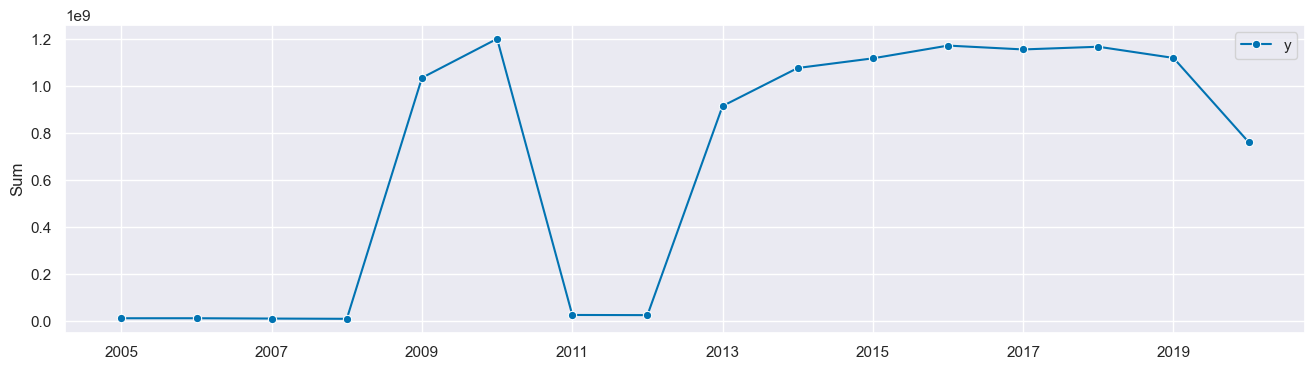

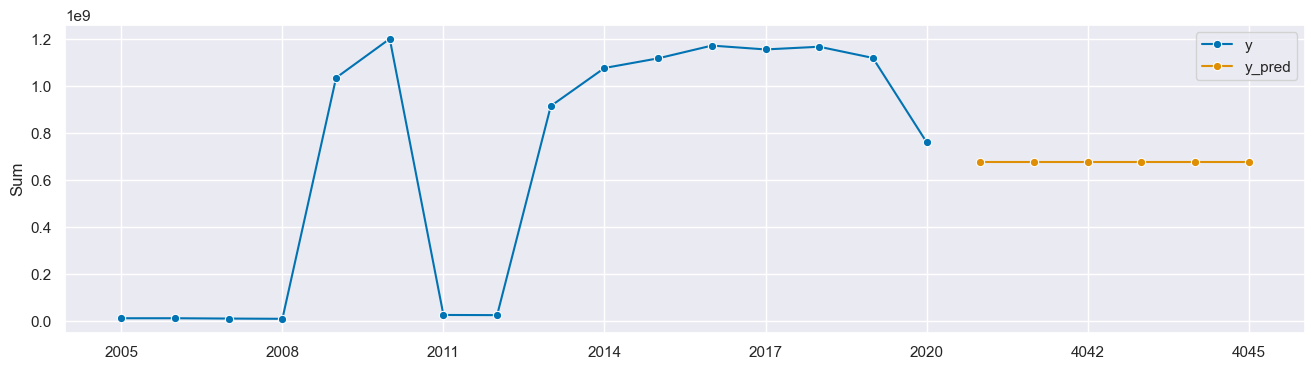

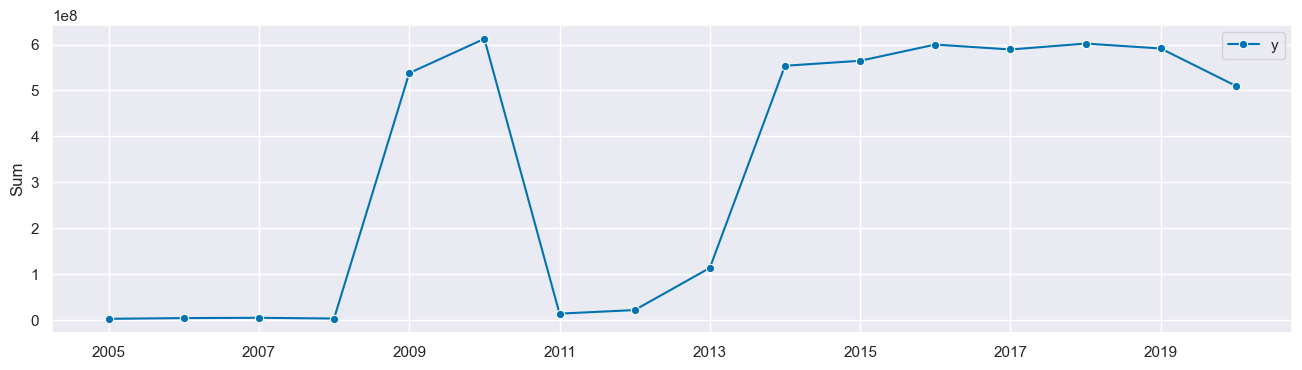

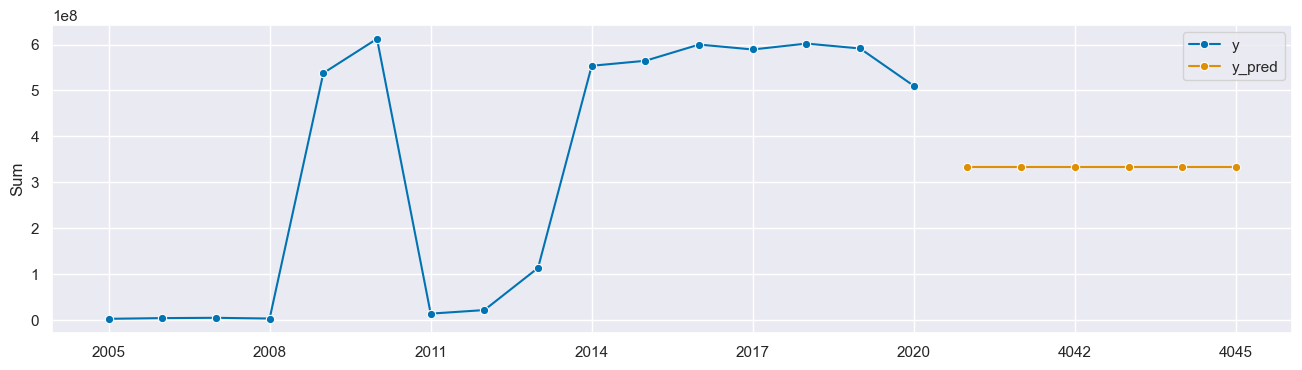

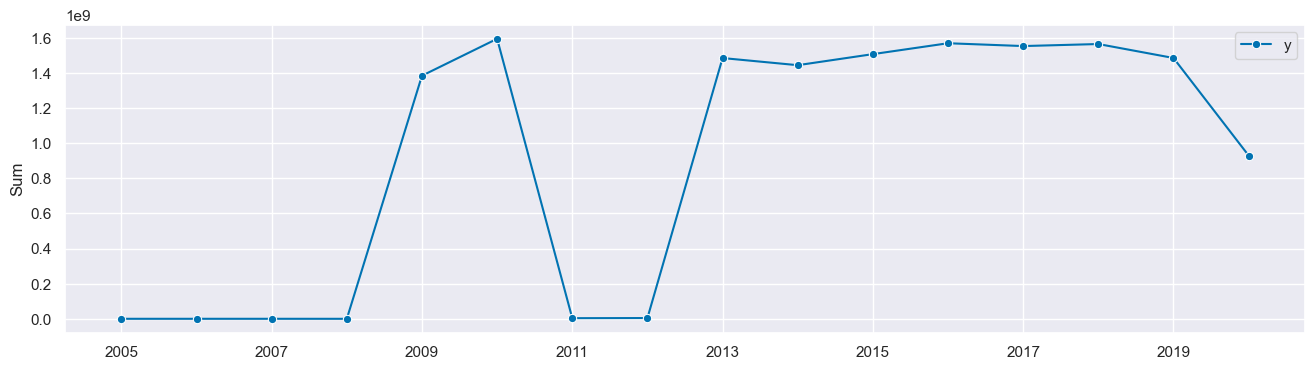

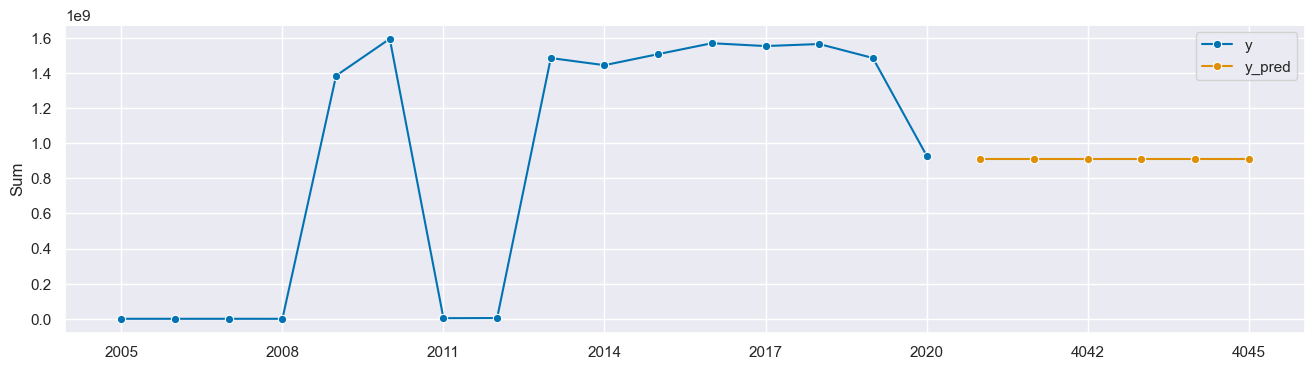

In [353]:
# fjarrvarmeproduktion
for region in fjarrvarmeproduktion.region.drop_duplicates(keep='first').reset_index(drop=True):
    print(region)
    data = fjarrvarmeproduktion[fjarrvarmeproduktion.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        print(fornybar_bransletyp)
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            print(fornybar_produktionssatt)
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].sort_values(by=['ar'], ascending=True).reset_index(drop=True)

            if not data.empty:
                # print(data.ar.max())
                # print(data.ar.min())
                ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
                # print(ey)
                # if not data.ar[~data.ar.isin(ey)]:
                # print(data.ar - ey)       
                
                y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
                # print(y)
                plot_series(y, labels=['y'])
                # Instantiate NaiveForecaster:
                fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
                forecaster = NaiveForecaster(strategy='mean')
                # Fit NaiveForecaster:
                forecaster.fit(y)

                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Check it out:
                plot_series(y, y_pred, labels=["y", "y_pred"])

                            
                # # Instantiate:
                # forecaster = ThetaForecaster(sp=12)

                # # Fit:
                # forecaster.fit(y)

                # # Predict:
                # y_pred_theta = forecaster.predict(fh)

                # Check it out:
                # plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

                # # Instantiate ARIMA
                # forecaster = AutoARIMA(sp=12)
                # # Fit Arima
                # forecaster.fit(y)
                # # Predict Arima 
                # y_pred_ARIMA = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ARIMA, labels=["y", "y_pred_naive", "y_pred_ARIMA"])

                # Instantiate AutoETS
                # forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
                # # Fit AutoETS
                # forecaster.fit(y)
                # # Predict AutoETS 
                # y_pred_ETS = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ETS, labels=["y", "y_pred_naive", "y_pred_ETS"])            
                # print("----------------")   

            # else:
            #     print("----------------")   


00 Riket
okand
slutanv. flerbostadshus
slutanv. fritidshus
slutanv. industri, byggverks.
slutanv. jordbruk,skogsbruk,fiske
slutanv. offentlig verksamhet
slutanv. sm�hus
slutanv. transporter
slutanv. �vriga tj�nster
summa br�nsletyp
01 Stockholms l�n
okand
slutanv. flerbostadshus
slutanv. fritidshus
slutanv. industri, byggverks.
slutanv. jordbruk,skogsbruk,fiske
slutanv. offentlig verksamhet
slutanv. sm�hus
slutanv. transporter
slutanv. �vriga tj�nster
summa br�nsletyp
0117 �ster�ker
okand
slutanv. flerbostadshus
slutanv. fritidshus
slutanv. industri, byggverks.
slutanv. jordbruk,skogsbruk,fiske
slutanv. offentlig verksamhet
slutanv. sm�hus
slutanv. transporter
slutanv. �vriga tj�nster
summa br�nsletyp
0160 T�by
okand
slutanv. flerbostadshus
slutanv. fritidshus
slutanv. industri, byggverks.
slutanv. jordbruk,skogsbruk,fiske
slutanv. offentlig verksamhet
slutanv. sm�hus
slutanv. transporter
slutanv. �vriga tj�nster
summa br�nsletyp
0180 Stockholm
okand
slutanv. flerbostadshus
slutanv. fr

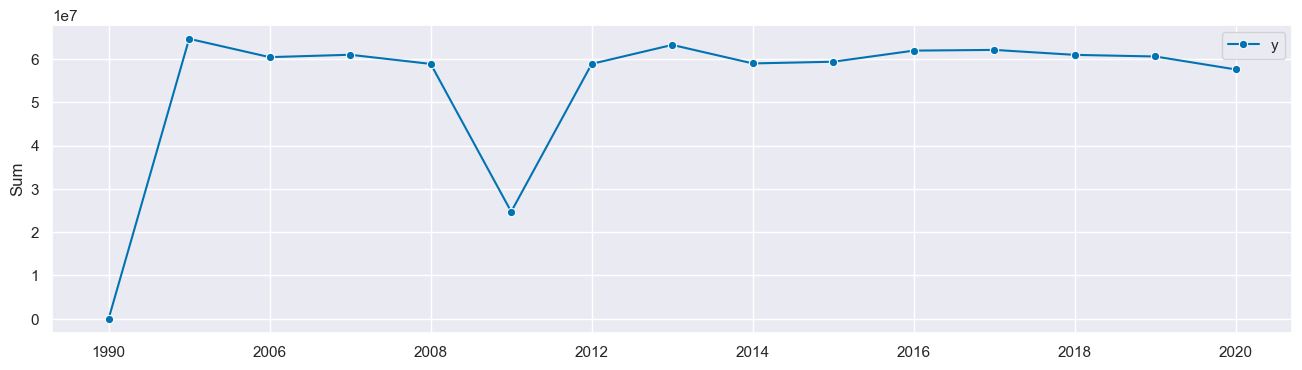

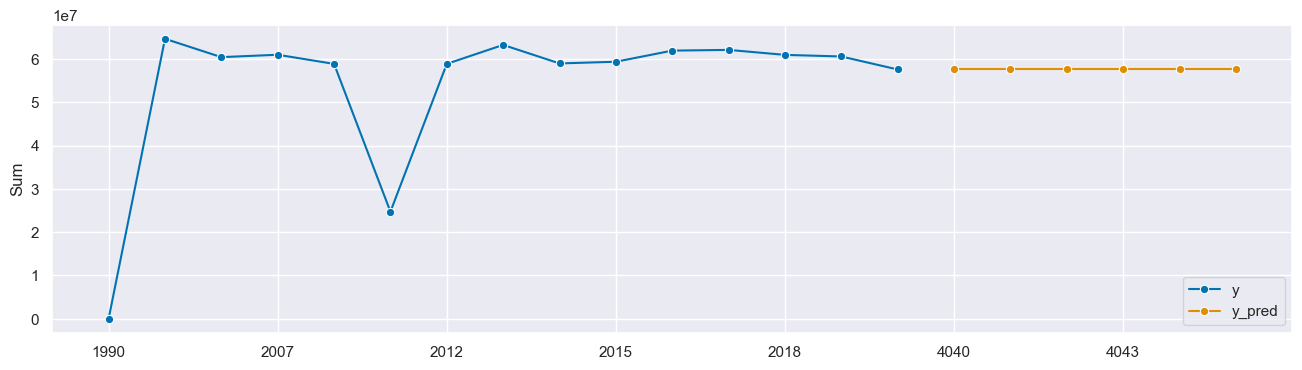

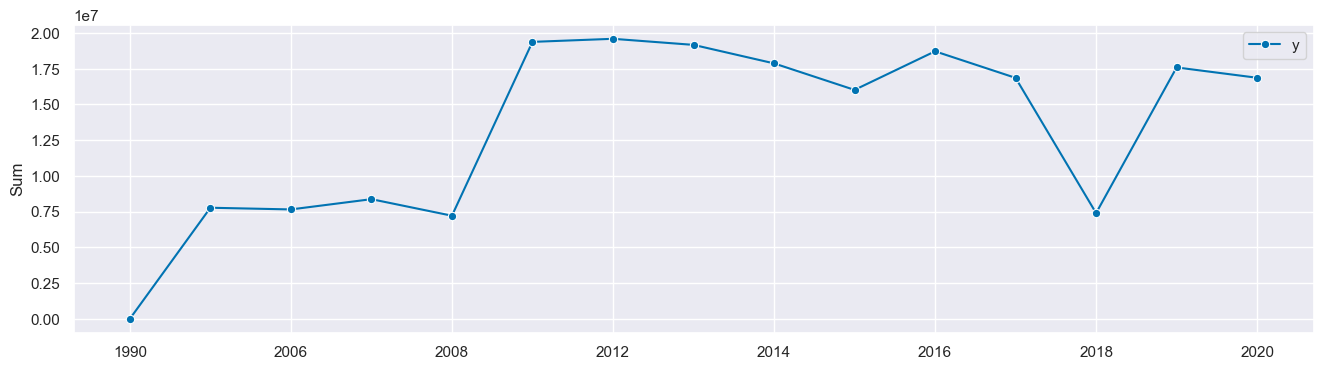

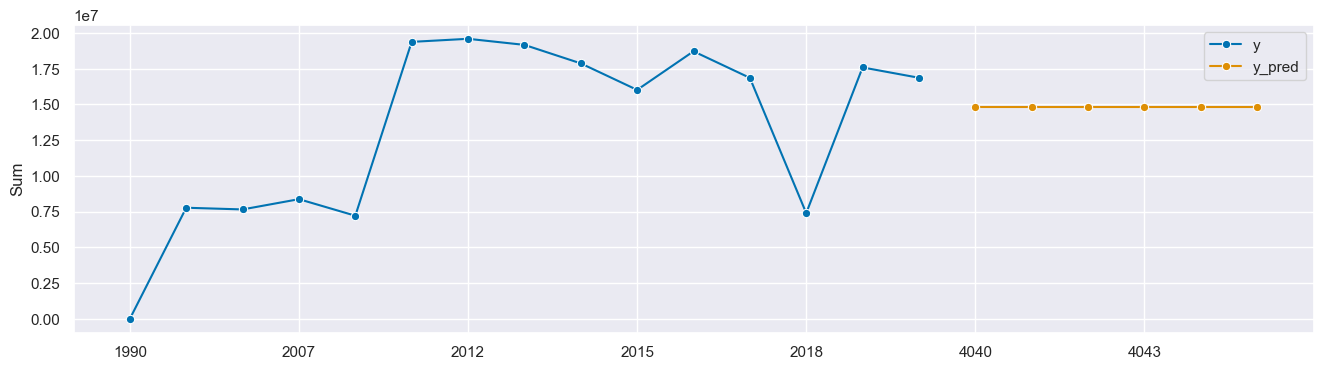

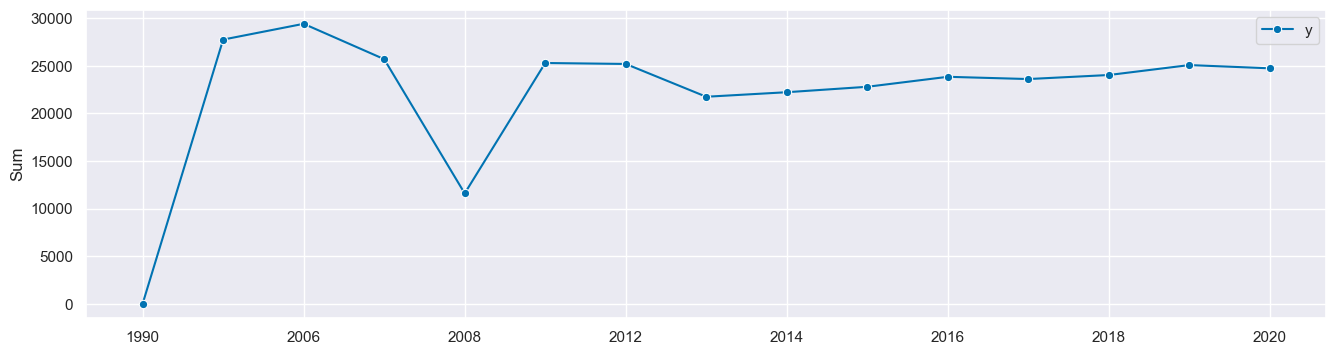

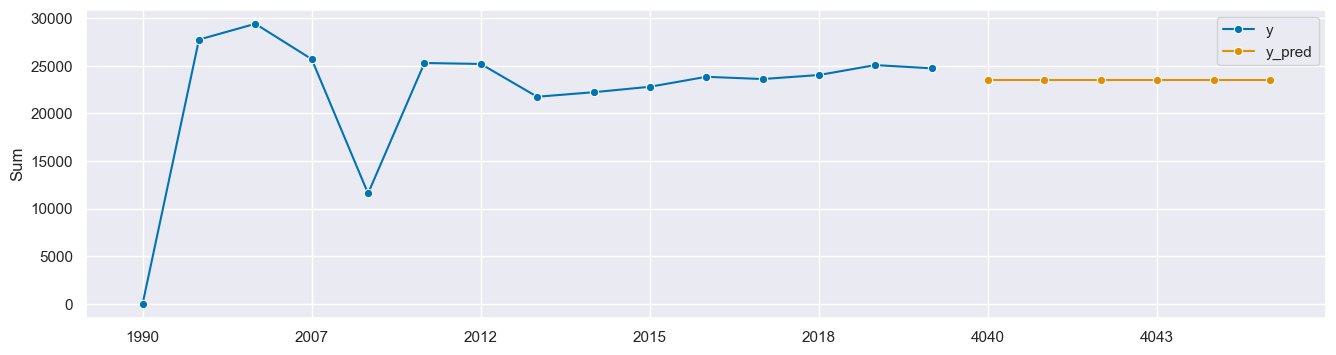

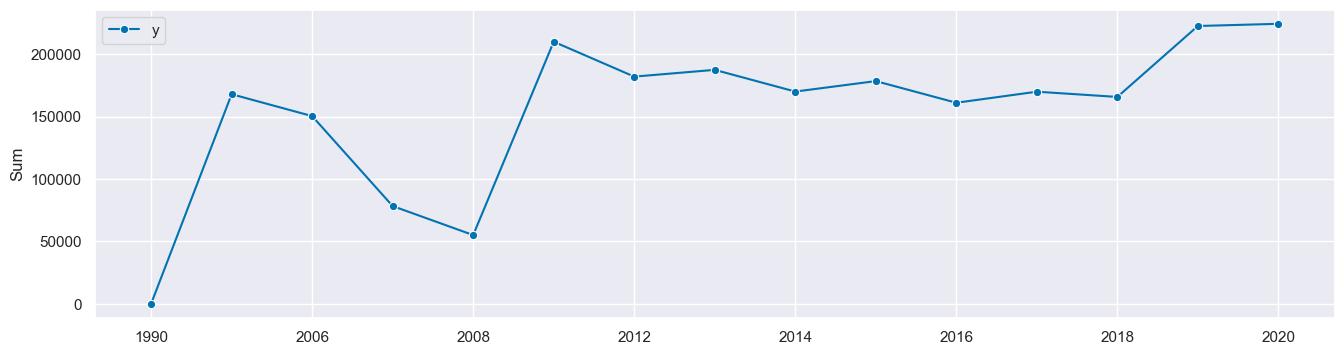

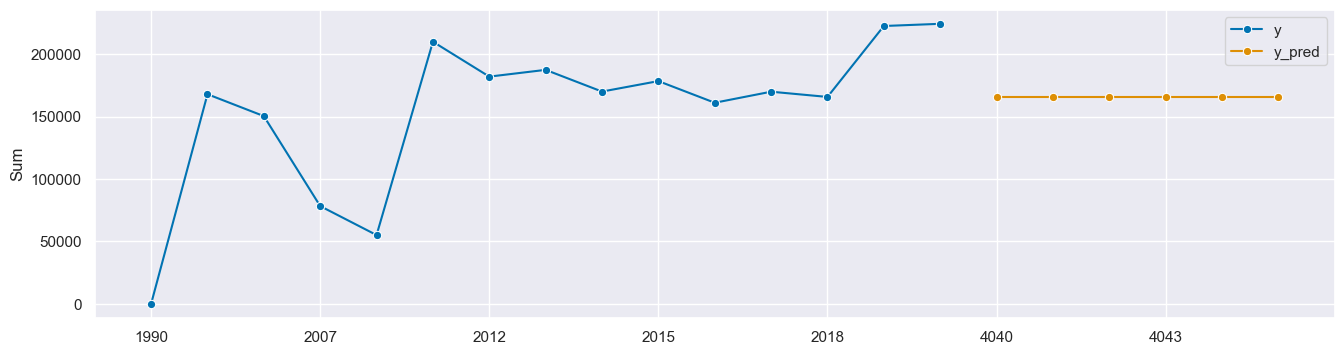

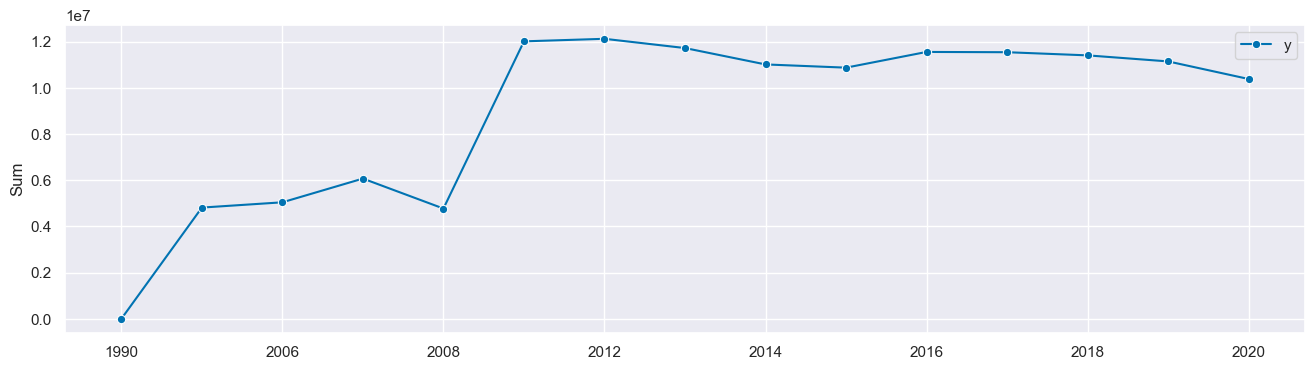

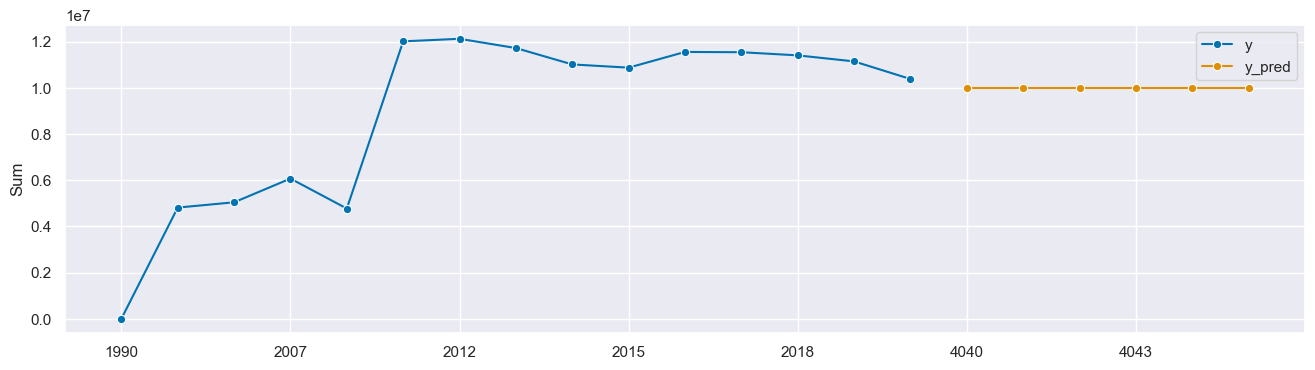

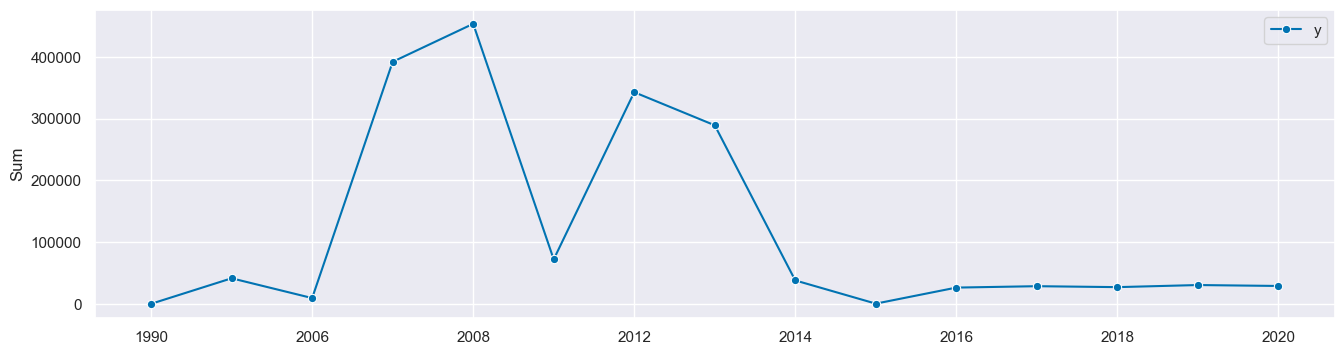

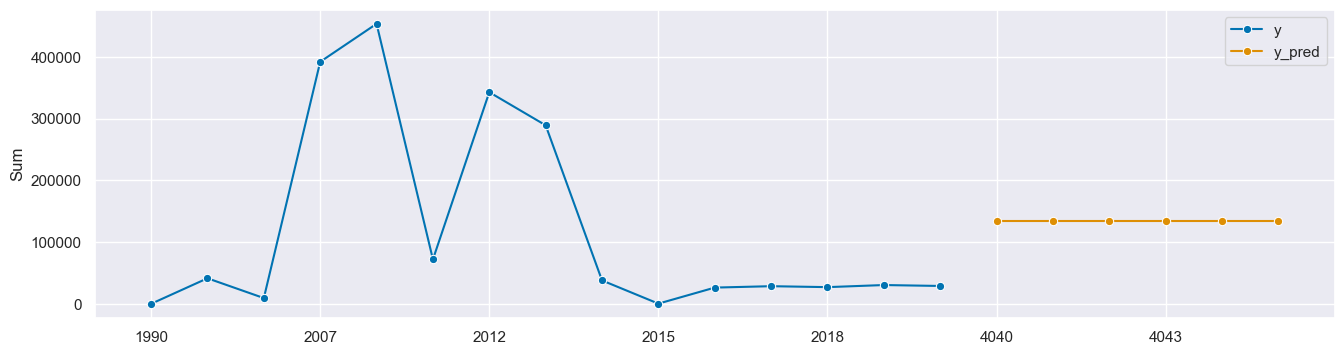

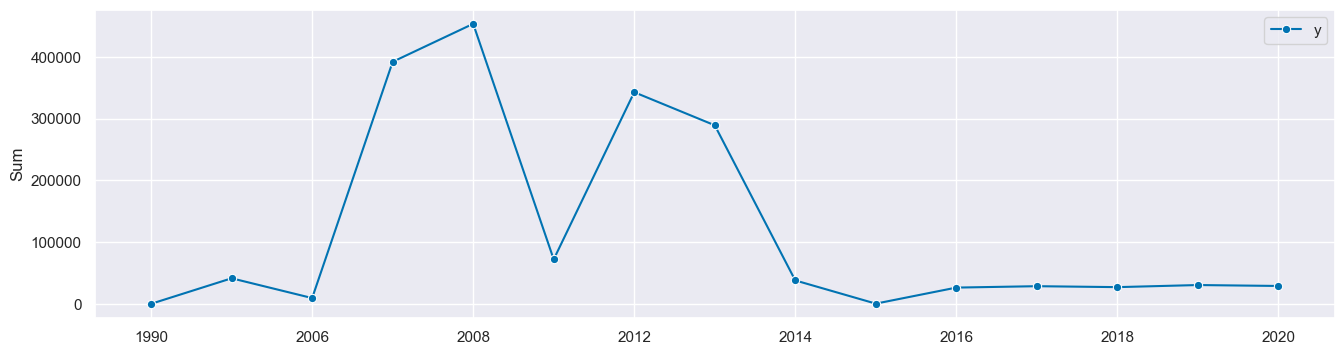

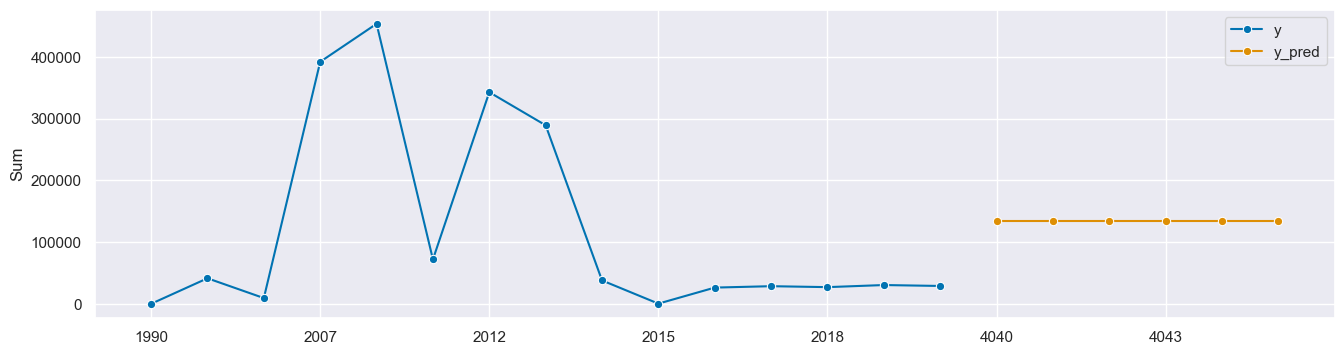

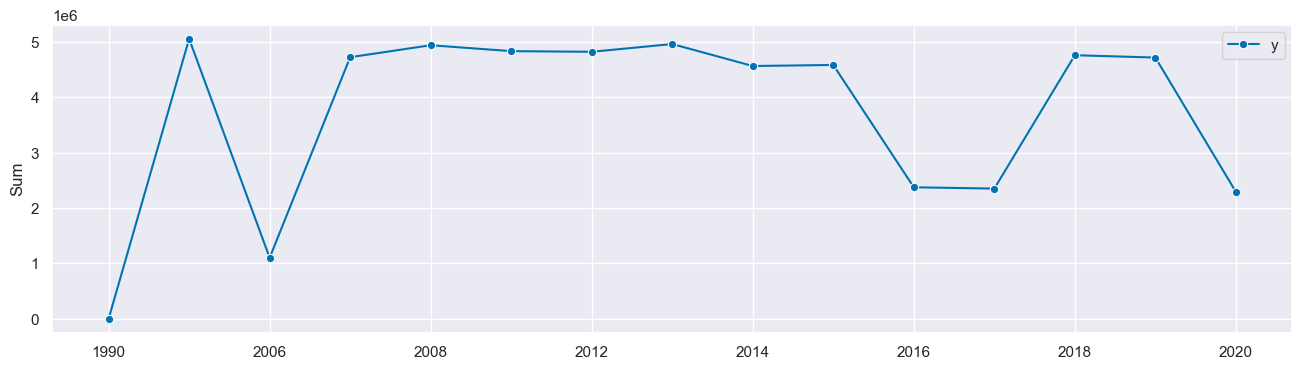

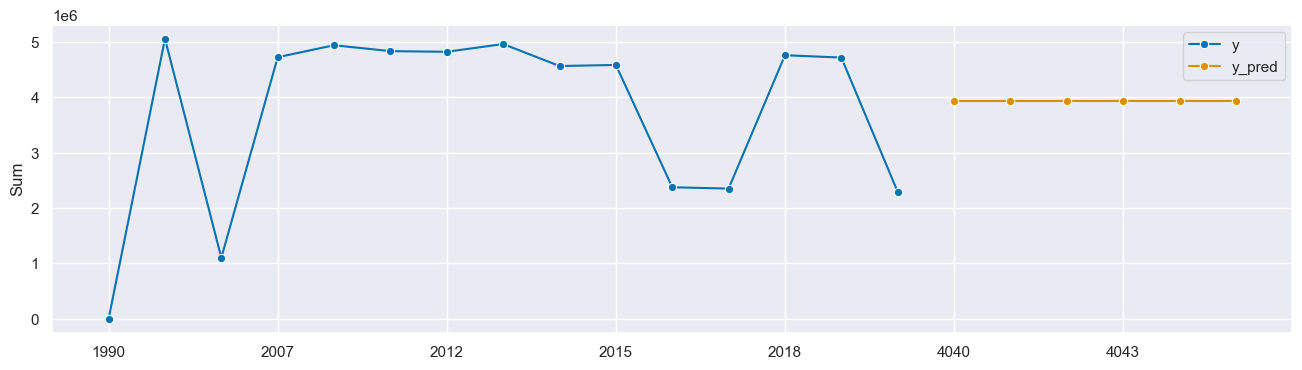

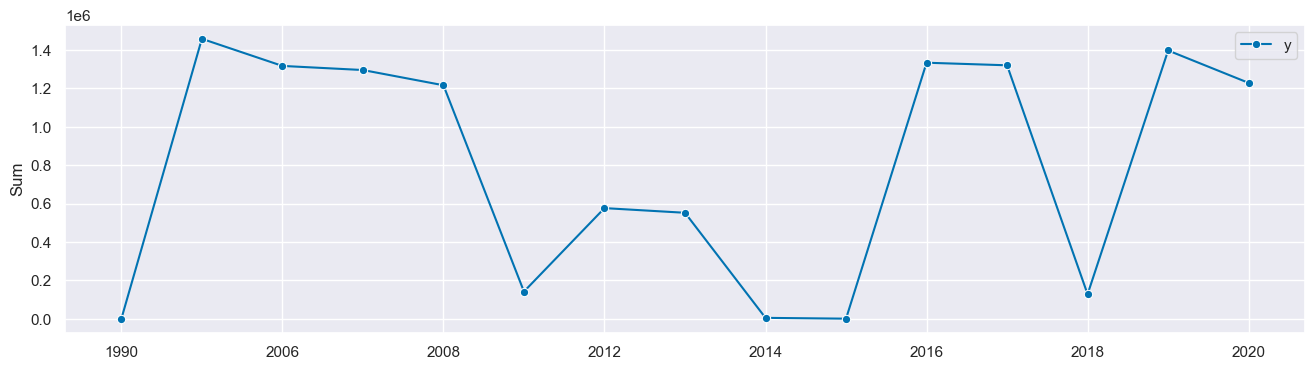

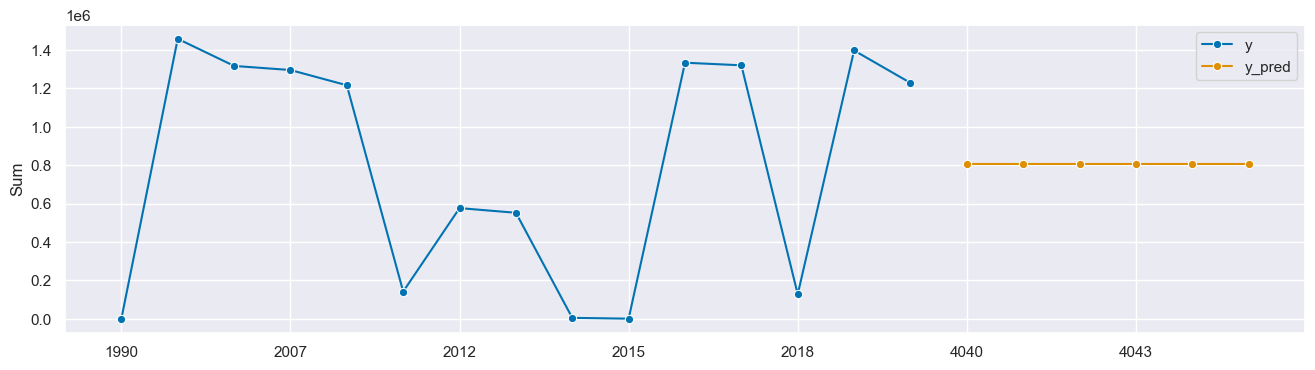

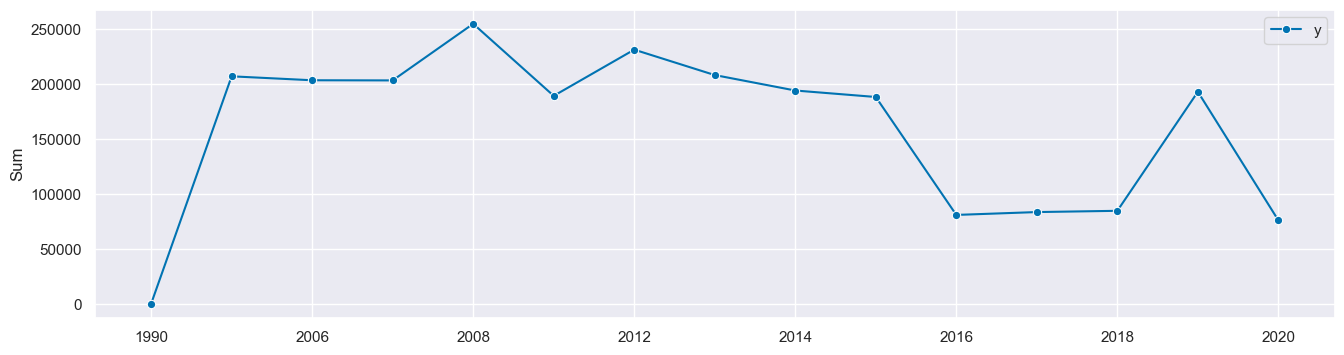

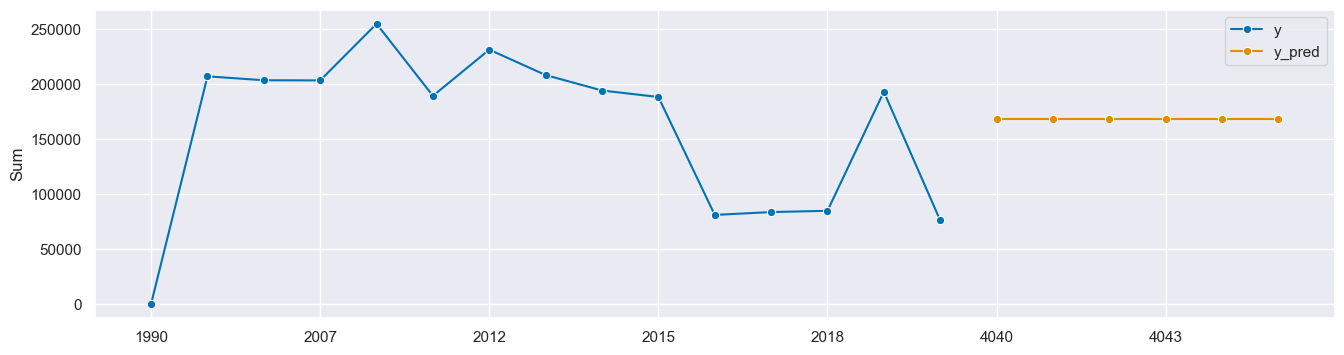

In [354]:
# slutanvandning
for region in slutanvandning.region.drop_duplicates(keep='first').reset_index(drop=True):
    print(region)
    data = slutanvandning[slutanvandning.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        print(fornybar_bransletyp)
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        for forbrukarkategori in data.forbrukarkategori.drop_duplicates(keep='first').reset_index(drop=True):
            print(forbrukarkategori)
            data = data[data.forbrukarkategori == forbrukarkategori].sort_values(by=['ar'], ascending=True).reset_index(drop=True)

            if not data.empty:
                # print(data.ar.max())
                # print(data.ar.min())
                ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
                # print(ey)
                # if not data.ar[~data.ar.isin(ey)]:
                # print(data.ar - ey)       
                
                y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
                # print(y)
                plot_series(y, labels=['y'])
                # Instantiate NaiveForecaster:
                fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
                forecaster = NaiveForecaster(strategy='mean')
                # Fit NaiveForecaster:
                forecaster.fit(y)

                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Check it out:
                plot_series(y, y_pred, labels=["y", "y_pred"])

                            
                # # Instantiate:
                # forecaster = ThetaForecaster(sp=12)

                # # Fit:
                # forecaster.fit(y)

                # # Predict:
                # y_pred_theta = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

                # # Instantiate ARIMA
                # forecaster = AutoARIMA(sp=12)
                # # Fit Arima
                # forecaster.fit(y)
                # # Predict Arima 
                # y_pred_ARIMA = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ARIMA, labels=["y", "y_pred_naive", "y_pred_ARIMA"])

                # * Instantiate AutoETS
                # forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
                # # Fit AutoETS
                # forecaster.fit(y)
                # # Predict AutoETS 
                # y_pred_ETS = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ETS, labels=["y", "y_pred_naive", "y_pred_ETS"])            
                # print("----------------")   

            # else:
            #     print("----------------")   




In [355]:
bransleforbrukning.columns

Index(['ar', 'fornybar_bransletyp', 'produktionsslag', 'Sum'], dtype='object')

fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Program

kraftv�rme-v�rmeverk, enbart v�rmeproduktion
kraftv�rme-v�rmeverk, kraftv�rmedrift
summa
icke-fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packag

kraftv�rme-v�rmeverk, enbart v�rmeproduktion
kraftv�rme-v�rmeverk, kraftv�rmedrift
summa
okand
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\ts

kraftv�rme-v�rmeverk, enbart v�rmeproduktion
kraftv�rme-v�rmeverk, kraftv�rmedrift
summa


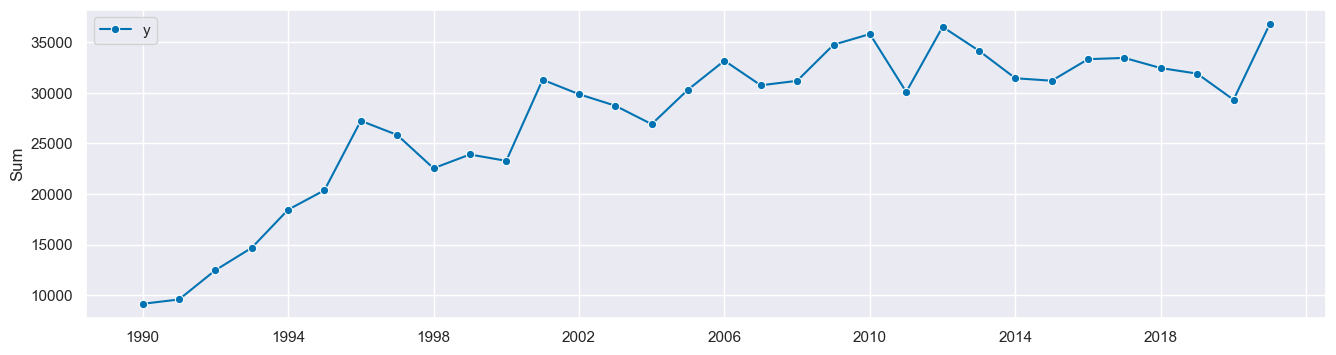

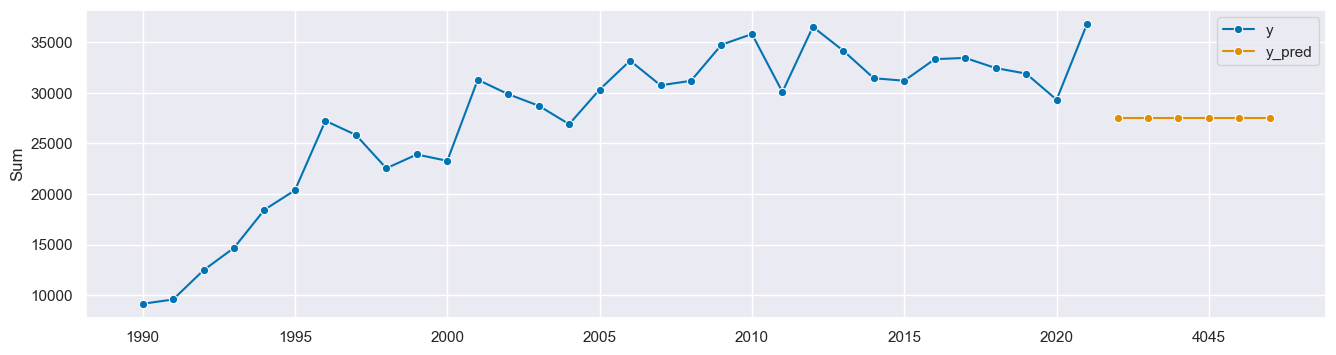

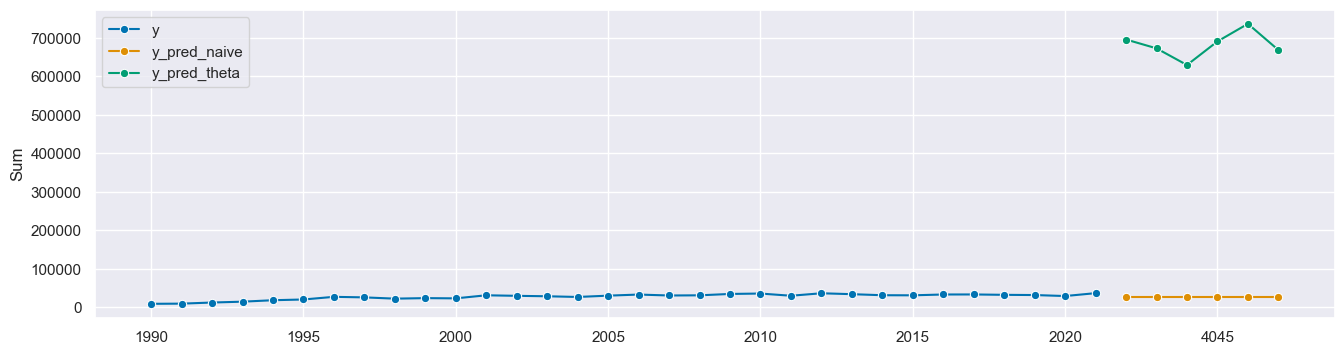

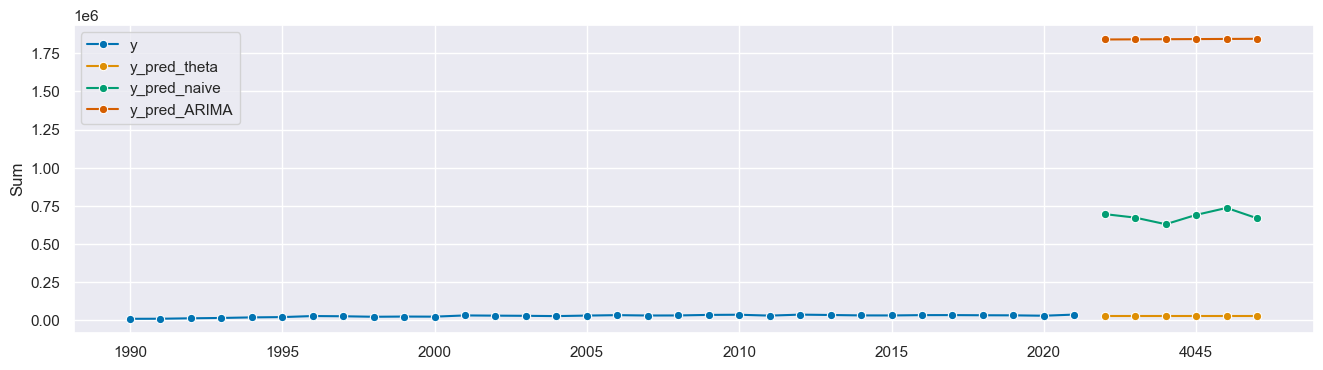

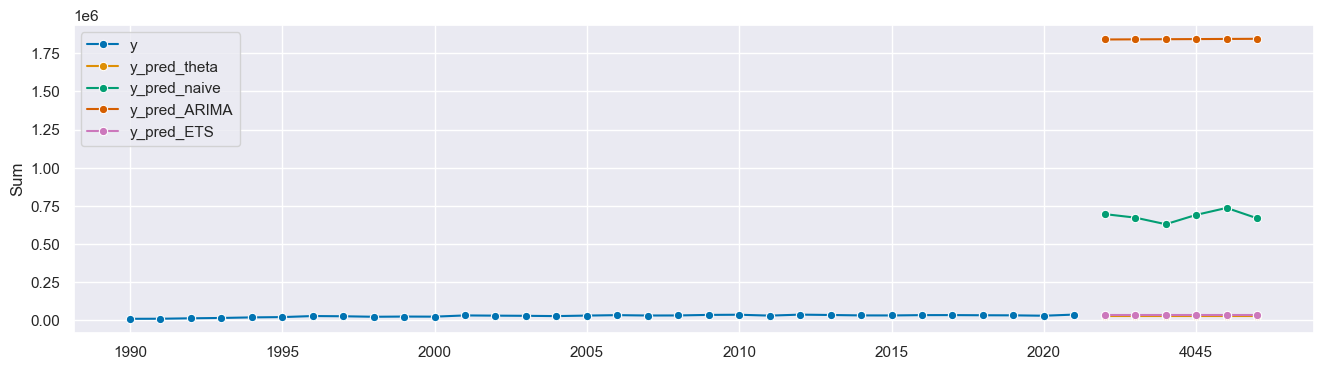

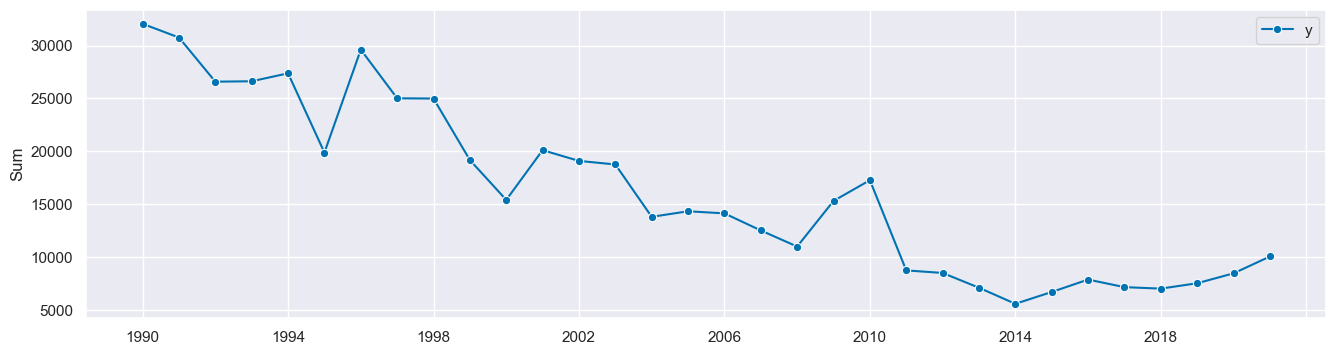

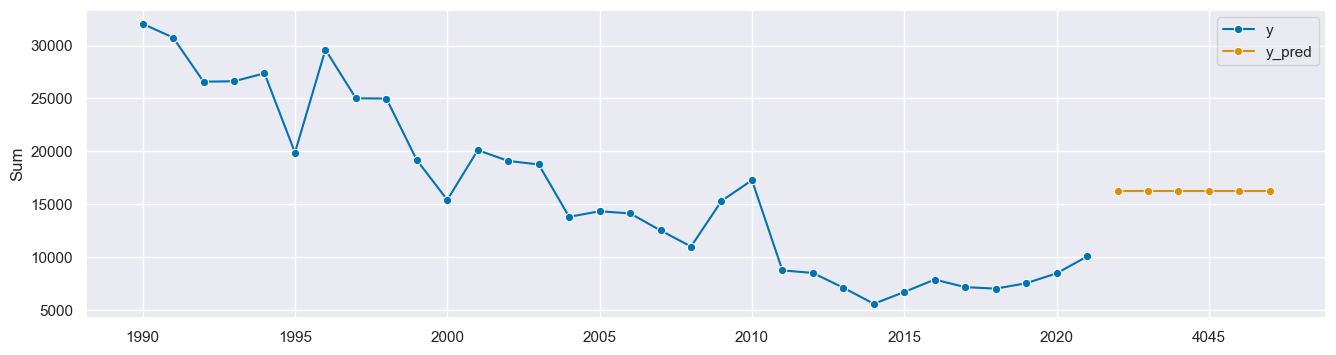

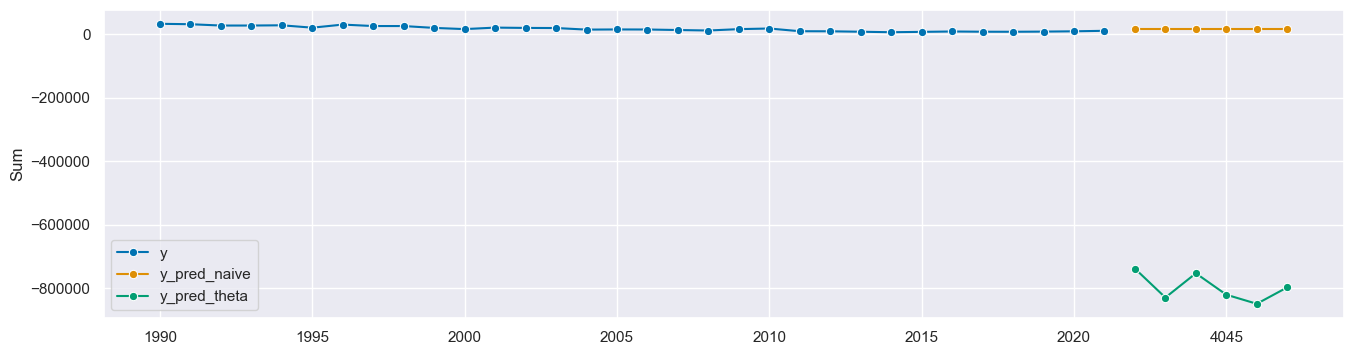

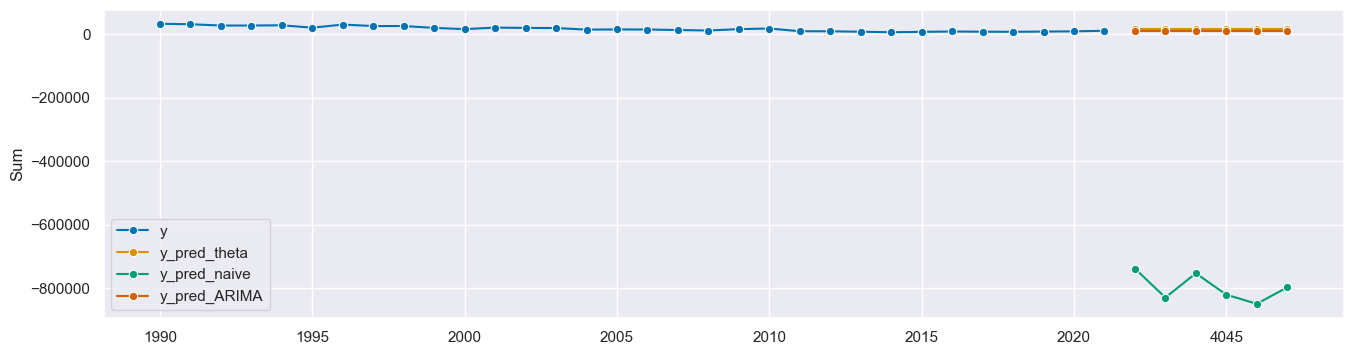

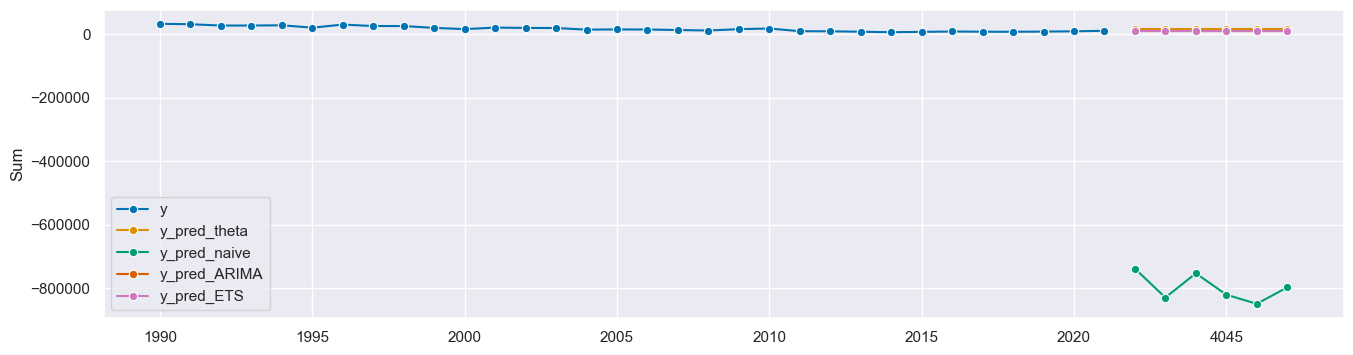

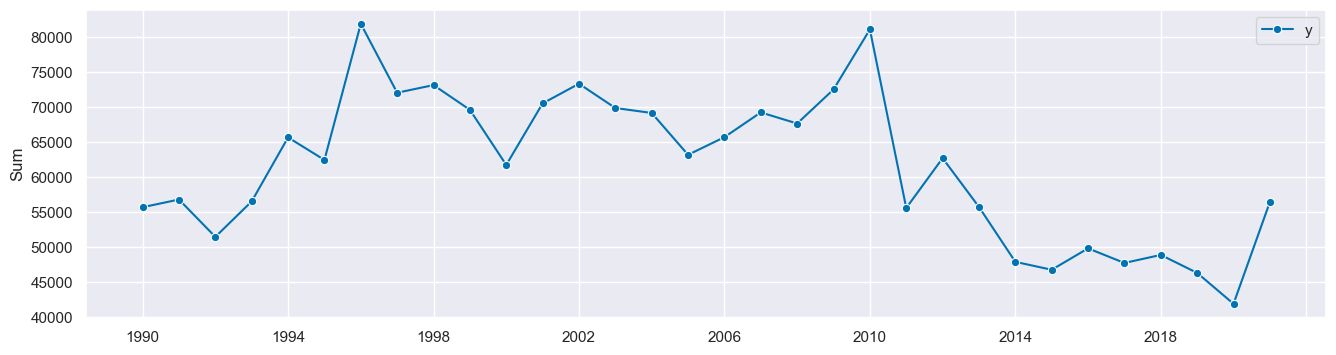

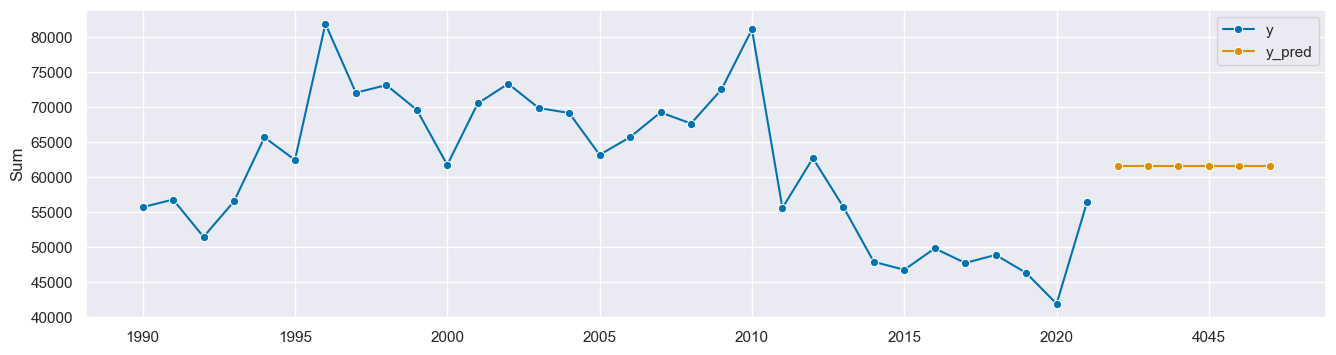

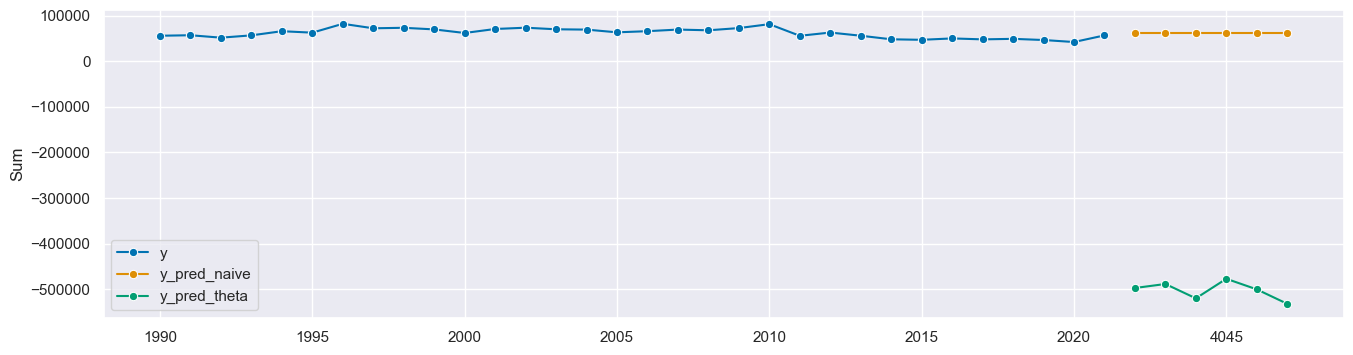

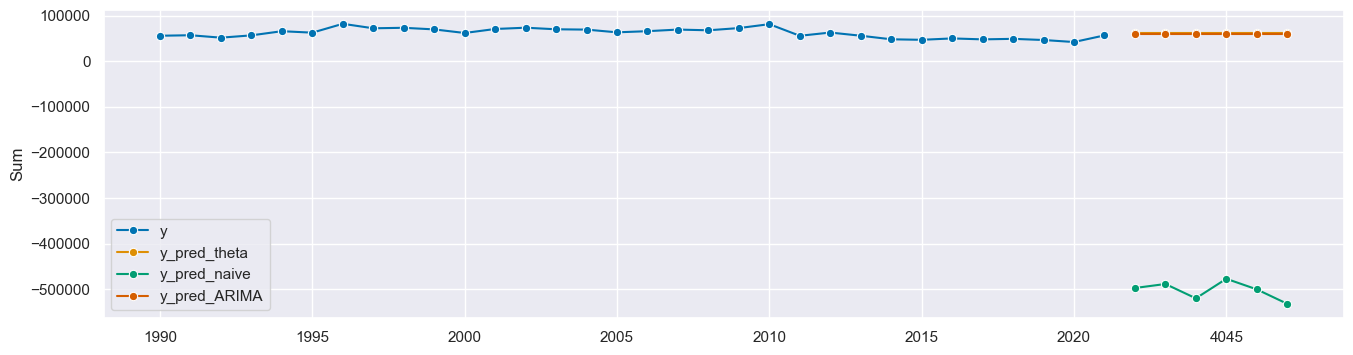

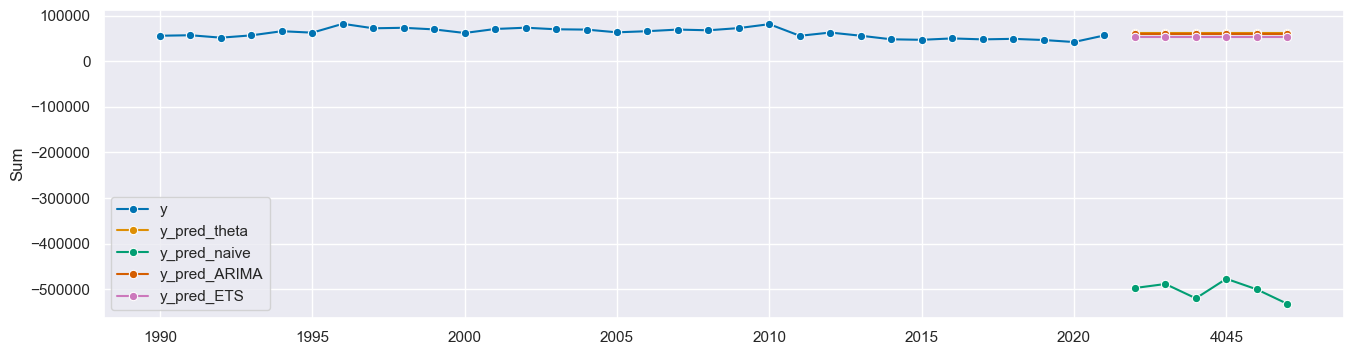

In [356]:
# bransleforbrukning


for fornybar_bransletyp in bransleforbrukning.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
    print(fornybar_bransletyp)
    data = bransleforbrukning[bransleforbrukning.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)    
    for produktionsslag in data.produktionsslag.drop_duplicates(keep='first').reset_index(drop=True):
        print(produktionsslag)
        data = data[data.produktionsslag == produktionsslag].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        if not data.empty:
            # print(data.ar.max())
            # print(data.ar.min())
            ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
            # print(ey)
            # if not data.ar[~data.ar.isin(ey)]:
            # print(data.ar - ey)       
            # print(data.Sum.astype(float))
            # data.Sum = data.Sum.astype(float)

            y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
            plot_series(y, labels=['y'])
            # Instantiate NaiveForecaster:
            fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
            
            forecaster = NaiveForecaster(strategy='mean')
            # Fit NaiveForecaster:
            forecaster.fit(y)

            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Check it out:
            plot_series(y, y_pred, labels=["y", "y_pred"])

                        
            # Instantiate:
            forecaster = ThetaForecaster(sp=12)

            # Fit:
            forecaster.fit(y)

            # Predict:
            y_pred_theta = forecaster.predict(fh)

            # Check it out:
            plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

            # Instantiate ARIMA
            forecaster = AutoARIMA(sp=12)
            # Fit Arima
            forecaster.fit(y)
            # Predict Arima 
            y_pred_ARIMA = forecaster.predict(fh)

            # Check it out:
            plot_series(y, y_pred, y_pred_theta, y_pred_ARIMA, labels=["y", "y_pred_theta", "y_pred_naive", "y_pred_ARIMA"])

            # Instantiate AutoETS
            forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
            # Fit AutoETS
            forecaster.fit(y)
            # Predict AutoETS 
            y_pred_ETS = forecaster.predict(fh)

            # Check it out:
            plot_series(y, y_pred, y_pred_theta, y_pred_ARIMA, y_pred_ETS, labels=["y", "y_pred_theta", "y_pred_naive", "y_pred_ARIMA", "y_pred_ETS"])            
            # print("----------------")   

        # else:
        #     print("----------------")   






00 Riket
fornybar
fornybar


ValueError: Coercion of integer pd.Index to pd.RangeIndex failed. Please provide `y_train` with a pd.RangeIndex.

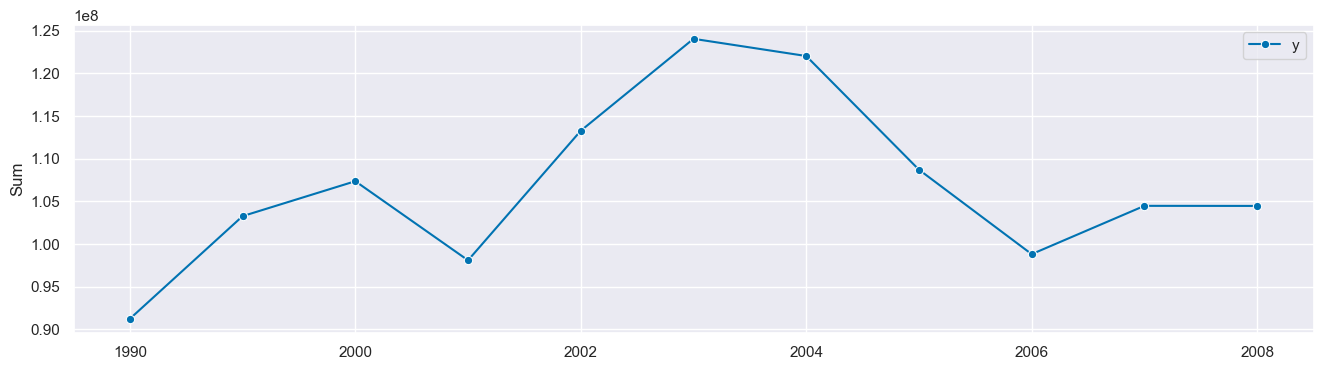

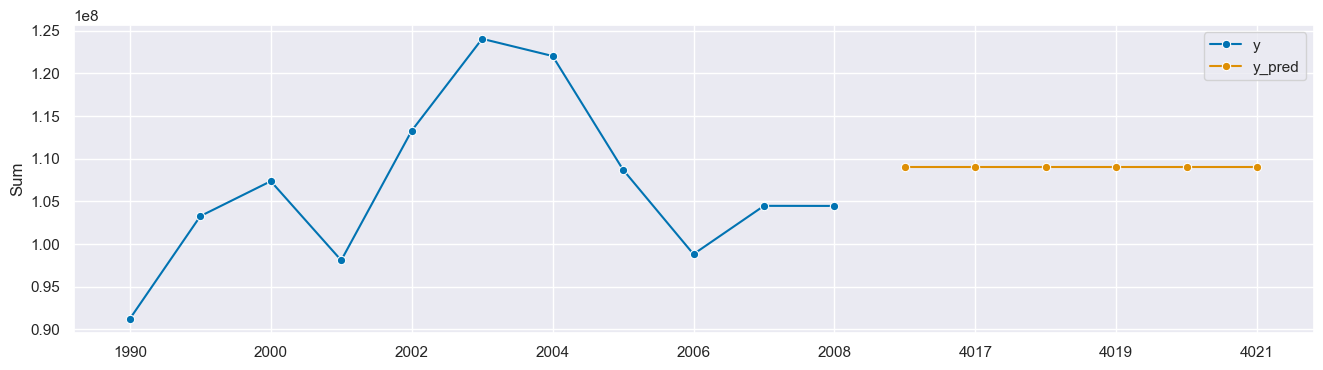

In [361]:
# energidata

for region in energidata.region.drop_duplicates(keep='first').reset_index(drop=True):
    print(region)
    data = energidata[energidata.region == region].reset_index(drop=True)    
    for fornybar_energityp in data.fornybar_energityp.drop_duplicates(keep='first').reset_index(drop=True):
        print(fornybar_energityp)
        data = data[data.fornybar_energityp == fornybar_energityp].sort_values(by=['ar'], ascending=True).reset_index(drop=True)
        for fornybar_kategori in data.fornybar_kategori.drop_duplicates(keep='first').reset_index(drop=True):
            print(fornybar_kategori)
            data = data[data.fornybar_kategori == fornybar_kategori].sort_values(by=['ar'], ascending=True).reset_index(drop=True)

            if not data.empty:
                # print(data.ar.max())
                # print(data.ar.min())
                ey = pd.Series(range(data.ar.min(), data.ar.max()+1, 1))
                # print(ey)
                # if not data.ar[~data.ar.isin(ey)]:
                # print(data.ar - ey)       
                
                y = data[['ar', 'Sum']].set_index(['ar']).squeeze()
                # print(y)
                plot_series(y, labels=['y'])
                # Instantiate NaiveForecaster:
                fh = pd.Series(range(data.ar.max(), data.ar.max()+6, 1)).tolist()
                forecaster = NaiveForecaster(strategy='mean')
                # Fit NaiveForecaster:
                forecaster.fit(y)

                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Check it out:
                plot_series(y, y_pred, labels=["y", "y_pred"])

                            
                # # Instantiate:
                # forecaster = ThetaForecaster(sp=12)

                # # Fit:
                # forecaster.fit(y)

                # # Predict:
                # y_pred_theta = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])

                # # Instantiate ARIMA
                # forecaster = AutoARIMA(sp=12)
                # # Fit Arima
                # forecaster.fit(y)
                # # Predict Arima 
                # y_pred_ARIMA = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ARIMA, labels=["y", "y_pred_naive", "y_pred_ARIMA"])

                # # Instantiate AutoETS
                # forecaster = AutoETS(auto=True, n_jobs=-1, sp=12)
                # # Fit AutoETS
                # forecaster.fit(y)
                # # Predict AutoETS 
                # y_pred_ETS = forecaster.predict(fh)

                # # Check it out:
                # plot_series(y, y_pred, y_pred_ETS, labels=["y", "y_pred_naive", "y_pred_ETS"])            
                # print("----------------")   

            # else:
            #     print("----------------")   


